In [271]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
from typing import Union
import matplotlib.patches as mpatches

sns.set_palette("pastel")
%matplotlib inline

## 1. Laden des Rohdatensatzes

### 1.1 Laden der Frage-Codes

Zur besseren Verarbeitung der Datensätze werden die zugehörigen Codes der Fragen geladen und verwendet. 

In [31]:
with open('code.json', 'r') as f:
  code_data = json.load(f)

In [33]:
df_code = pd.DataFrame(code_data)
codes = df_code["Variable"].tolist()

In [34]:
df_code.head()

Variable    Fragetyp                                   Fragetext  \
0  60371597  Skalafrage                     2.1 ein hohes Einkommen   
1  60371598  Skalafrage             2.2 gute Aufstiegsmöglichkeiten   
2  60371599  Skalafrage             2.3 einen sicheren Arbeitsplatz   
3  60371600  Skalafrage      2.4 viele Kontakte zu anderen Menschen   
4  60371601  Skalafrage  2.5 eine gute/kollegiale Arbeitsatmosphäre   

                                               Werte Zeichenlimit  Wert  
0  {'<leer>': 'Ungültig / Keine Antwort', '1': 'u...         None  None  
1  {'<leer>': 'Ungültig / Keine Antwort', '1': 'u...         None  None  
2  {'<leer>': 'Ungültig / Keine Antwort', '1': 'u...         None  None  
3  {'<leer>': 'Ungültig / Keine Antwort', '1': 'u...         None  None  
4  {'<leer>': 'Ungültig / Keine Antwort', '1': 'u...         None  None

### 1.2 Laden der Stichproben Ergebnisse

Die Stichproben Ergebnisse werden in ein DataFrame geladen und die Spaltenüberschriften (Fragetexte) mit ihren jeweiligen Codes ersetzt.

In [35]:
df_results_raw = pd.read_excel('./data/pia_master_raw.xlsx', index_col=0)

In [36]:
print(len(codes))
print(len(df_results_raw.columns))

53
55


In [37]:
df_results_raw.head()

ein hohes Einkommen  gute Aufstiegsmˆglichkeiten  \
Bogen                                                     
1                        4                            4   
2                        4                            5   
3                        4                            2   
4                        5                            4   
5                        5                            4   

       einen sicheren Arbeitsplatz  viele Kontakte zu anderen Menschen†  \
Bogen                                                                     
1                                5                                    4   
2                                5                                    5   
3                                5                                    4   
4                                5                                    4   
5                                5                                    3   

       eine gute/kollegiale Arbeitsatmosph‰re†  das Gef¸hl, etwas zu leisten†  \
Bogen                                                                           
1                                            4                              5   
2                                            5                              4   
3                                            5                              4   
4                                            4                              4   
5                                            5                              5   

       das Gef¸hl, anerkannt zu werden†  \
Bogen                                     
1                                     5   
2                                     5   
3                                     5   
4                                     4   
5                                     4   

       Mˆglichkeiten, sich um andere Menschen zu k¸mmern  \
Bogen                                                      
1                                                      4   
2                                                      4   
3                                                      2   
4                                                      2   
5                                                      3   

       Mˆglichkeiten, eigene Ideen einzubringen†  \
Bogen                                              
1                                              4   
2                                              4   
3                                              4   
4                                              3   
5                                              4   

       Mˆglichkeiten, etwas N¸tzliches f¸r die Gesellschaft zu tun†  ...  \
Bogen                                                                ...   
1                                                      4             ...   
2                                                      2             ...   
3                                                      2             ...   
4                                                      3             ...   
5                                                      3             ...   

       an Gott glauben†  \
Bogen                     
1                     2   
2                     1   
3                     2   
4                     1   
5                     1   

       die Vielfalt der Menschen anerkennen und respektieren  \
Bogen                                                          
1                                                      5       
2                                                      5       
3                                                      3       
4                                                      5       
5                                                      4       

       Bitte kreuze an, welcher Generation du zugehˆrig bist:  \
Bogen                                                           
1                                                      2        
2                                           

In [38]:
df_results = df_results_raw.rename(columns={
    col: codes[i] for i, col in enumerate(df_results_raw.columns) if col not in ["Bogen", 
                                                                             "Zeitstempel",
                                                                             "Datensatz-Ursprung"]})

In [39]:
df_results.head()

60371597  60371598  60371599  60371600  60371601  60371602  60371603  \
Bogen                                                                         
1             4         4         5         4         4         5         5   
2             4         5         5         5         5         4         5   
3             4         2         5         4         5         4         5   
4             5         4         5         4         4         4         4   
5             5         4         5         3         5         5         4   

       60371604  60371605  60371606  ...  60371647  60371648  60371649  \
Bogen                                ...                                 
1             4         4         4  ...         2         5         2   
2             4         4         2  ...         1         5         1   
3             2         4         2  ...         2         3         1   
4             2         3         3  ...         1         5         1   
5             3         4         3  ...         1         4         1   

      60371650  60371651  60371652  60371653  60371654  \
Bogen                                                    
1          2.0         6         1       1.0       3.0   
2          2.0         6         1       1.0       2.0   
3          1.0         4         1       1.0       3.0   
4          2.0         4         1       2.0       3.0   
5          2.0         5         1       1.0       3.0   

                  Zeitstempel  Datensatz-Ursprung  
Bogen                                              
1      02.07.2023 um 17:44:14                   O  
2      02.07.2023 um 17:50:50                   O  
3      02.07.2023 um 18:55:10                   M  
4      02.07.2023 um 19:00:41                   M  
5      02.07.2023 um 19:03:32                   M  

[5 rows x 55 columns]

### 1.3. Utility Functions

In [212]:
def get_answer_text(question_code: str, answer_res: Union[float, int, str] = None):
    if isinstance(answer_res, str):
        _res = answer_res
    else:
        _res = int(answer_res) if answer_res != 0 else '<leer>'
    t_code = df_code[df_code["Variable"] == question_code]
    question_type = t_code["Fragetyp"].values[0]
    assert (answer_res is not None and question_type != 'Offene Frage') or (answer_res is None and question_type == 'Offene Frage'), f"Ungültige Antwortmöglichkeit für Fragentyp {question_type}"
    answer_dict = t_code["Werte"].values[0]
    out = answer_dict[str(_res)] if answer_res is not None else answer_dict
    return out

In [244]:
def get_question_text(question_code: str):
    return df_code[df_code["Variable"] == question_code]["Fragetext"].values[0]

In [243]:
get_question_text('60371598')

1    2.2 gute Aufstiegsmöglichkeiten
Name: Fragetext, dtype: object


'2.2 gute Aufstiegsmöglichkeiten'

In [211]:
get_answer_text('60371654', 0.0)

<leer>


'Ungültig / Keine Antwort'

## 2. Deskriptive Beschreibung der Stichproben Ergebnisse

Im ersten Schritte werden fehlende Werte ausgewertet.

<Axes: >

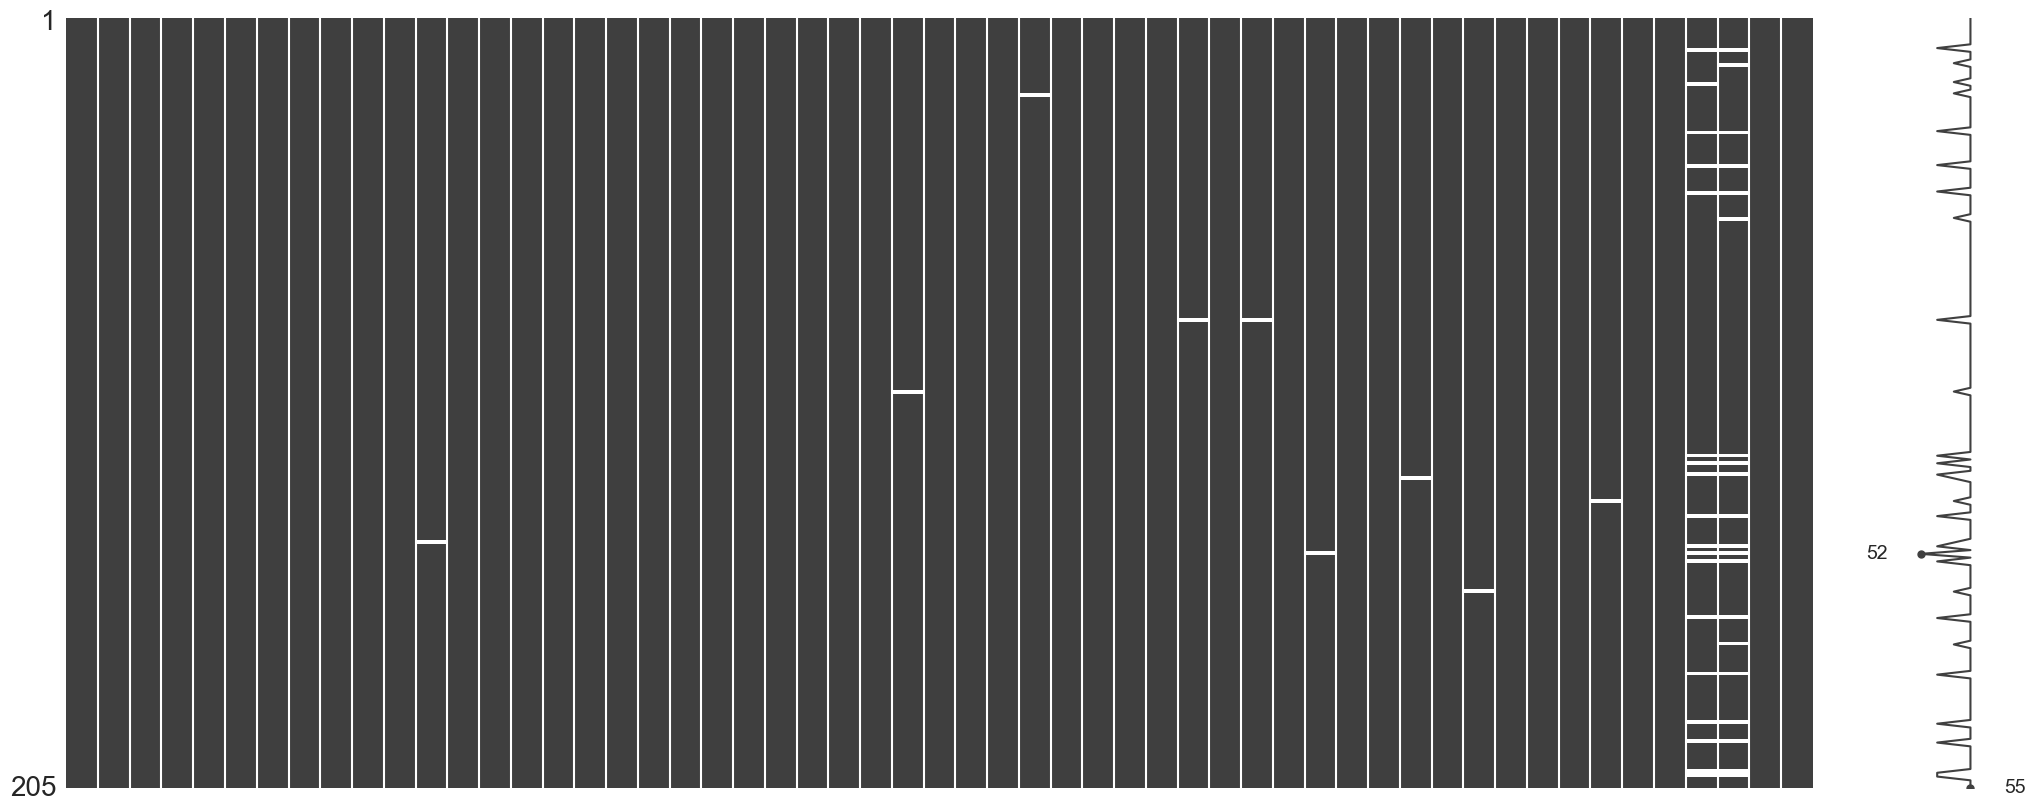

In [40]:
msno.matrix(df_results)

Füllen der fehlenden Werte mit Nullen

In [218]:
df_results.fillna(0, inplace=True)

### 2.1. Gliederung der Fragetypen

Die Umfrage enthält 3 Fragetypen.
- Skalafragen - Antwortmöglichkeiten werden mittels kategorischen numerischen Werten auf einer Ordinalskala dargestellt.
- 1 aus n - Antwortmöglichkeiten werden mittels kategorischen numerischen Werten auf einer Nominalskala dargestellt.
- Offene Frage - Antwort besteht aus einem Freitext

In [45]:
skala_ids = df_code[df_code["Fragetyp"] == "Skalafrage"]["Variable"].tolist()
one_of_n_ids = df_code[df_code["Fragetyp"] == "1 aus n"]["Variable"].tolist()
open_q_ids = df_code[df_code["Fragetyp"] == "Offene Frage"]["Variable"].tolist()

Neben den fachlichen Fragen der Umfrage, gibt es auch Fragetypen, welche zur Klassifierung der Umfrage Ergebnisse dienen.
- Bitte kreuze an, welcher Generation du zugehörig bist
- Welchem Geschlecht fühlst du dich zugehörig?
- Bitte wähle deinen höchsten formalen Bildungsabschluss aus:
- Bist du derzeit berufstätig?
- In welcher Beschäftigungsform befindest du dich?
- In welchem Wirtschaftssektor bist du beschäftigt?

In [46]:
generation_col = '60371649'
gender_col = '60371650'
academic_col = '60371651'
working_col = '60371652'
work_form_col = '60371653'
economic_sector_col = '60371654'

In [47]:
print(skala_ids)
print(one_of_n_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609', '60371615', '60371616', '60371617', '60371618', '60371619', '60371620', '60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']
['60371613', '60371614', '60371649', '60371650', '60371651', '60371652', '60371653', '60371654']


### 2.2. Deskriptive Analyse der Umfrageergebnisse

In [49]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205 entries, 1 to 205
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   60371597            205 non-null    int64  
 1   60371598            205 non-null    int64  
 2   60371599            205 non-null    int64  
 3   60371600            205 non-null    int64  
 4   60371601            205 non-null    int64  
 5   60371602            205 non-null    int64  
 6   60371603            205 non-null    int64  
 7   60371604            205 non-null    int64  
 8   60371605            205 non-null    int64  
 9   60371606            205 non-null    int64  
 10  60371607            205 non-null    int64  
 11  60371608            204 non-null    float64
 12  60371609            205 non-null    int64  
 13  60371612            205 non-null    object 
 14  60371613            205 non-null    int64  
 15  60371614            205 non-null    int64  
 16  60371615     

In [50]:
df_results.describe()

60371597    60371598    60371599    60371600    60371601    60371602  \
count  205.000000  205.000000  205.000000  205.000000  205.000000  205.000000   
mean     3.970732    3.653659    4.439024    3.629268    4.653659    4.160976   
std      0.625537    0.955915    0.749143    0.959535    0.561902    0.759540   
min      2.000000    1.000000    1.000000    1.000000    1.000000    2.000000   
25%      4.000000    3.000000    4.000000    3.000000    4.000000    4.000000   
50%      4.000000    4.000000    5.000000    4.000000    5.000000    4.000000   
75%      4.000000    4.000000    5.000000    4.000000    5.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

        60371603    60371604    60371605    60371606  ...    60371645  \
count  205.00000  205.000000  205.000000  205.000000  ...  205.000000   
mean     4.15122    3.097561    3.912195    3.478049  ...    4.073171   
std      0.82934    1.129048    0.908618    0.988044  ...    0.773021   
min      1.00000    1.000000    1.000000    1.000000  ...    2.000000   
25%      4.00000    2.000000    4.000000    3.000000  ...    4.000000   
50%      4.00000    3.000000    4.000000    4.000000  ...    4.000000   
75%      5.00000    4.000000    5.000000    4.000000  ...    5.000000   
max      5.00000    5.000000    5.000000    5.000000  ...    5.000000   

         60371646    60371647    60371648    60371649    60371650    60371651  \
count  204.000000  205.000000  205.000000  205.000000  204.000000  205.000000   
mean     3.137255    1.824390    4.243902    1.604878    1.563725    4.990244   
std      0.977976    1.166691    0.923030    0.675173    0.516580    1.150406   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      2.000000    1.000000    4.000000    1.000000    1.000000    4.000000   
50%      3.000000    1.000000    4.000000    1.000000    2.000000    5.000000   
75%      4.000000    2.000000    5.000000    2.000000    2.000000    6.000000   
max      5.000000    5.000000    5.000000    3.000000    3.000000    6.000000   

         60371652    60371653    60371654  
count  205.000000  187.000000  185.000000  
mean     1.082927    1.358289    2.675676  
std      0.276447    0.609048    0.492004  
min      1.000000    1.000000    1.000000  
25%      1.000000    1.000000    2.000000  
50%      1.000000    1.000000    3.000000  
75%      1.000000    2.000000    3.000000  
max      2.000000    4.000000    3.000000  

[8 rows x 52 columns]

Verteilung der Gesamtanzahl der Umfrageergebnisse auf die unterschiedlichen Generationen.

In [57]:
gen_count = df_results[generation_col].value_counts()
print(gen_count)

60371649
1    103
2     80
3     22
Name: count, dtype: int64


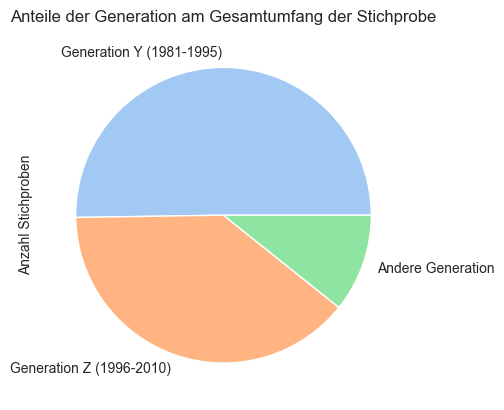

In [70]:
fig = gen_count.plot(kind='pie', labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
plt.ylabel("Anzahl Stichproben")
plt.title("Anteile der Generation am Gesamtumfang der Stichprobe")
plt.show(fig)

Verteilung der Gesamtanzahl der Umfrageergebnisse auf die unterschiedlichen Generationen unter Betrachtung von Geschelcht, Ausbildungsgrad bzw. Arbeitsverhältnis.

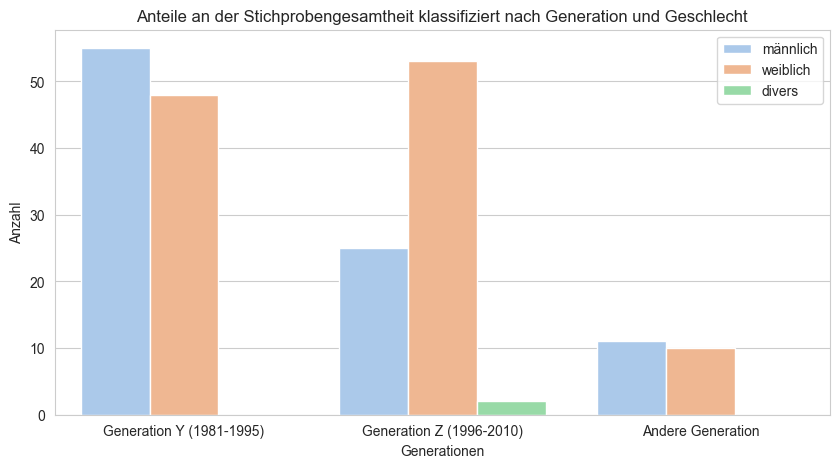

In [188]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_results, x=generation_col, hue=gender_col)
plt.xlabel("Generationen")
fig.axes.set_xticklabels(labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
plt.ylabel("Anzahl")
plt.title("Anteile an der Stichprobengesamtheit klassifiziert nach Generation und Geschlecht")
plt.legend(labels=["männlich", "weiblich", "divers"])
plt.show(fig)

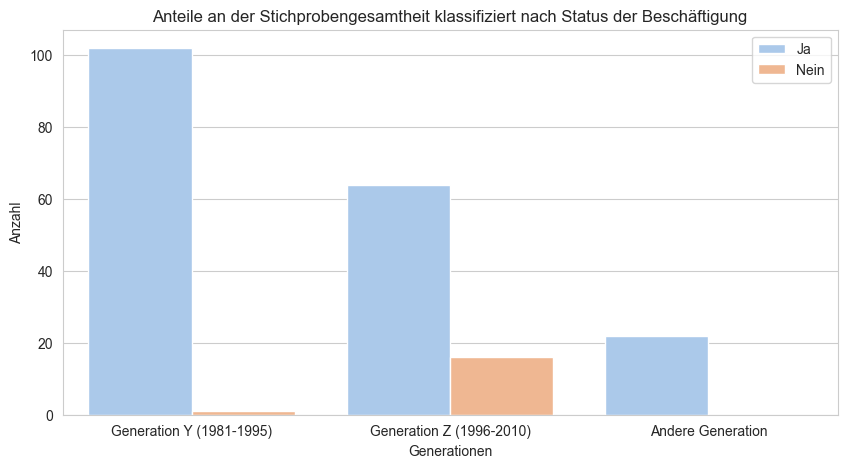

In [217]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_results, x=generation_col, hue=working_col)
plt.xlabel("Generationen")
fig.axes.set_xticklabels(labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
plt.ylabel("Anzahl")
plt.title("Anteile an der Stichprobengesamtheit klassifiziert nach Status der Beschäftigung")
plt.legend(labels=[get_answer_text(working_col, x) for x in sorted(df_results[working_col].unique())])
plt.show(fig)

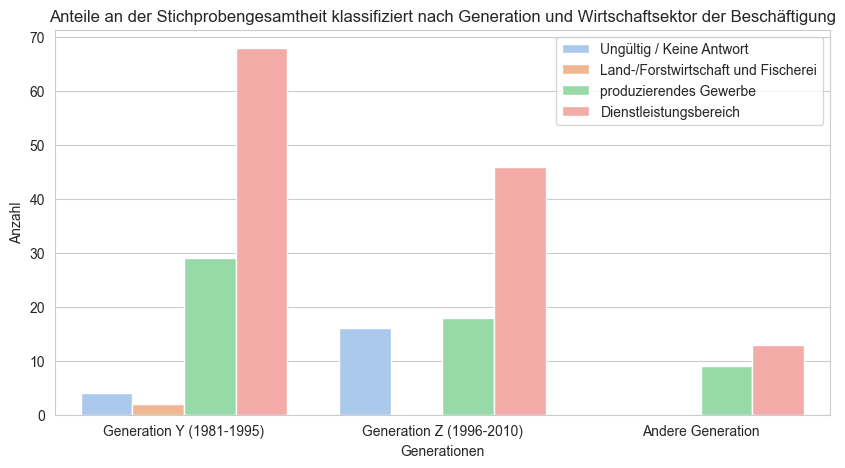

In [276]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_results, x=generation_col, hue=economic_sector_col)
plt.xlabel("Generationen")
fig.axes.set_xticklabels(labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
plt.ylabel("Anzahl")
plt.title("Anteile an der Stichprobengesamtheit klassifiziert nach Generation und Wirtschaftsektor der Beschäftigung")
plt.legend(labels=[get_answer_text(economic_sector_col, x) for x in sorted(df_results[economic_sector_col].unique())])
plt.show(fig)

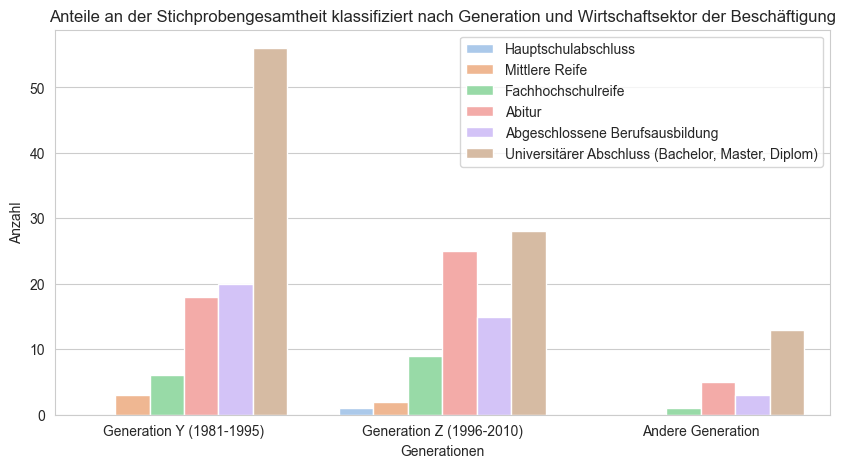

In [216]:
plt.figure(figsize=(10,5))
fig = sns.countplot(data=df_results, x=generation_col, hue=academic_col)
plt.xlabel("Generationen")
fig.axes.set_xticklabels(labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
plt.ylabel("Anzahl")
plt.title("Anteile an der Stichprobengesamtheit klassifiziert nach Generation und Wirtschaftsektor der Beschäftigung")
plt.legend(labels=[get_answer_text(academic_col, x) for x in sorted(df_results[academic_col].unique())])
plt.show(fig)

### 2.3. Deskriptive Analyse der fachlihen Fragestellungen

In [224]:
skala_fach_ids = [x for x in skala_ids if int(x) <= 60371648]
one_of_n_fach_ids = [x for x in one_of_n_ids if int(x) <= 60371648]
num_fach_cols = skala_fach_ids + one_of_n_fach_ids

print(skala_fach_ids)
print(one_of_n_fach_ids)

['60371597', '60371598', '60371599', '60371600', '60371601', '60371602', '60371603', '60371604', '60371605', '60371606', '60371607', '60371608', '60371609', '60371615', '60371616', '60371617', '60371618', '60371619', '60371620', '60371624', '60371625', '60371626', '60371627', '60371628', '60371629', '60371630', '60371631', '60371632', '60371633', '60371634', '60371635', '60371636', '60371637', '60371638', '60371639', '60371640', '60371641', '60371642', '60371643', '60371644', '60371645', '60371646', '60371647', '60371648']
['60371613', '60371614']


In [246]:
for col in num_fach_cols:
    print(f"{col}: {get_question_text(col)}")

60371597: 2.1 ein hohes Einkommen
60371598: 2.2 gute Aufstiegsmöglichkeiten
60371599: 2.3 einen sicheren Arbeitsplatz
60371600: 2.4 viele Kontakte zu anderen Menschen
60371601: 2.5 eine gute/kollegiale Arbeitsatmosphäre
60371602: 2.6 das Gefühl, etwas zu leisten
60371603: 2.7 das Gefühl, anerkannt zu werden
60371604: 2.8 Möglichkeiten, sich um andere Menschen zu kümmern
60371605: 2.9 Möglichkeiten, eigene Ideen einzubringen
60371606: 2.10 Möglichkeiten, etwas Nützliches für die Gesellschaft zu tun
60371607: 2.11 die Möglichkeit, etwas zu tun, das ich sinnvoll ﬁnde
60371608: 2.12 genügend Freizeit neben der Berufstätigkeit
60371609: 2.13 Flexible Arbeitszeiten (z.B. Home-Ofﬁce oder Gleitzeit)
60371615: 4.1 Größe des Unternehmens
60371616: 4.2 Ruf des Unternehmens
60371617: 4.3 Standort des Unternehmens
60371618: 4.4 Bereitstellung neuster Technologien am Arbeitsplatz
60371619: 4.5 Flache Hierarchien (auf Augenhöhe miteinander arbeiten)
60371620: 4.6 Nachhaltigkeit  Corporate Social Resp

In [225]:
df_results[num_fach_cols].corr()

60371597  60371598  60371599  60371600  60371601  60371602  \
60371597  1.000000  0.261690  0.048476 -0.009999 -0.168443 -0.082891   
60371598  0.261690  1.000000 -0.115200  0.174641 -0.032765  0.218946   
60371599  0.048476 -0.115200  1.000000  0.029772  0.118440  0.047487   
60371600 -0.009999  0.174641  0.029772  1.000000  0.288009  0.277342   
60371601 -0.168443 -0.032765  0.118440  0.288009  1.000000  0.315045   
60371602 -0.082891  0.218946  0.047487  0.277342  0.315045  1.000000   
60371603  0.046369  0.122037  0.010969  0.249432  0.186572  0.459209   
60371604 -0.100048  0.058712  0.192525  0.540324  0.339412  0.398879   
60371605 -0.237406  0.179279 -0.072718  0.294206  0.237783  0.439655   
60371606 -0.199325  0.098308  0.165404  0.306775  0.326172  0.452170   
60371607 -0.160636  0.156155 -0.007767  0.200250  0.232132  0.483779   
60371608  0.128112 -0.109630  0.284069  0.022347  0.114800 -0.154400   
60371609  0.101423  0.028476  0.025893  0.052940  0.032805  0.009171   
60371615  0.209133  0.162380 -0.020929  0.092955 -0.118530 -0.106906   
60371616  0.056597  0.237541  0.115158  0.212330  0.117080  0.274490   
60371617 -0.084094 -0.140032  0.218598  0.024910  0.144875  0.016524   
60371618  0.012193  0.193476  0.062039  0.161819  0.096504  0.232713   
60371619 -0.086461  0.118281  0.097875  0.219004  0.298104  0.140782   
60371620 -0.117034  0.092005  0.101991  0.138578  0.113635  0.206514   
60371624  0.148836 -0.021372  0.312258 -0.057047  0.054675  0.087673   
60371625  0.418888  0.216313  0.000868 -0.073097 -0.094457 -0.028927   
60371626  0.195357  0.341888 -0.086360  0.070099 -0.130214  0.140610   
60371627 -0.192677  0.089782 -0.023743  0.152183  0.252571  0.372555   
60371628  0.078795 -0.011757  0.538089 -0.019618  0.172020  0.010761   
60371629 -0.222581 -0.030114  0.259404  0.333292  0.213809  0.288253   
60371630  0.048968  0.029062 -0.017642  0.011262 -0.054560  0.002013   
60371631  0.072217  0.300516  0.135113  0.151989  0.116669  0.410124   
60371632 -0.001806 -0.027452  0.063856  0.113842  0.127367  0.072570   
60371633 -0.200172  0.048034 -0.038770  0.192289  0.143270  0.083777   
60371634  0.182712  0.107885  0.102372  0.114560  0.136312  0.010821   
60371635  0.095633  0.128313 -0.102546  0.158328 -0.001532  0.159221   
60371636  0.131313 -0.144878  0.137249  0.002262  0.034869 -0.039784   
60371637  0.145040 -0.100709  0.227280 -0.091122 -0.054124 -0.104224   
60371638  0.095366 -0.133461  0.338864 -0.030053  0.059650 -0.017004   
60371639 -0.053738 -0.018658  0.151410 -0.104348  0.060993  0.034748   
60371640  0.044007  0.016780  0.146090  0.074834  0.119985  0.009239   
60371641 -0.002034  0.035078  0.097162  0.076482  0.209859  0.241526   
60371642 -0.087588  0.038724  0.056212  0.531125  0.239336  0.188982   
60371643  0.134645  0.132607  0.146174  0.059168  0.038493  0.204305   
60371644 -0.101810 -0.082525  0.153861  0.164648  0.312919  0.100833   
60371645  0.115962  0.180406  0.062763 -0.042554  0.081200  0.130120   
60371646 -0.135338  0.044407  0.085234  0.139322  0.066820  0.283846   
60371647  0.013073 -0.002058  0.183987  0.077302  0.033886  0.170351   
60371648 -0.233782  0.001762  0.049969  0.362724  0.239280  0.202428   
60371613 -0.278225 -0.170914 -0.007880  0.024895  0.064696  0.056034   
60371614  0.102963  0.368062 -0.124175  0.237339  0.056176  0.032275   

          60371603  60371604  60371605  60371606  ...  60371641  60371642  \
60371597  0.046369 -0.100048 -0.237406 -0.199325  ... -0.002034 -0.087588   
60371598  0.122037  0.058712  0.179279  0.098308  ...  0.035078  0.038724   
60371599  0.010969  0.192525 -0.072718  0.165404  ...  0.097162  0.056212   
60371600  0.249432  0.540324  0.294206  0.306775  ...  0.076482  0.531125   
60371601  0.186572  0.339412  0.237783  0.326172  ...  0.209859  0.239336   
60371602  0.459209  0.398879  0.439655  0.452170  ...  0.241526  0.188982   
60371603  1.000000  0.224982  0.329953  0.258314  ...  0.103514  0.171575   
60371604 

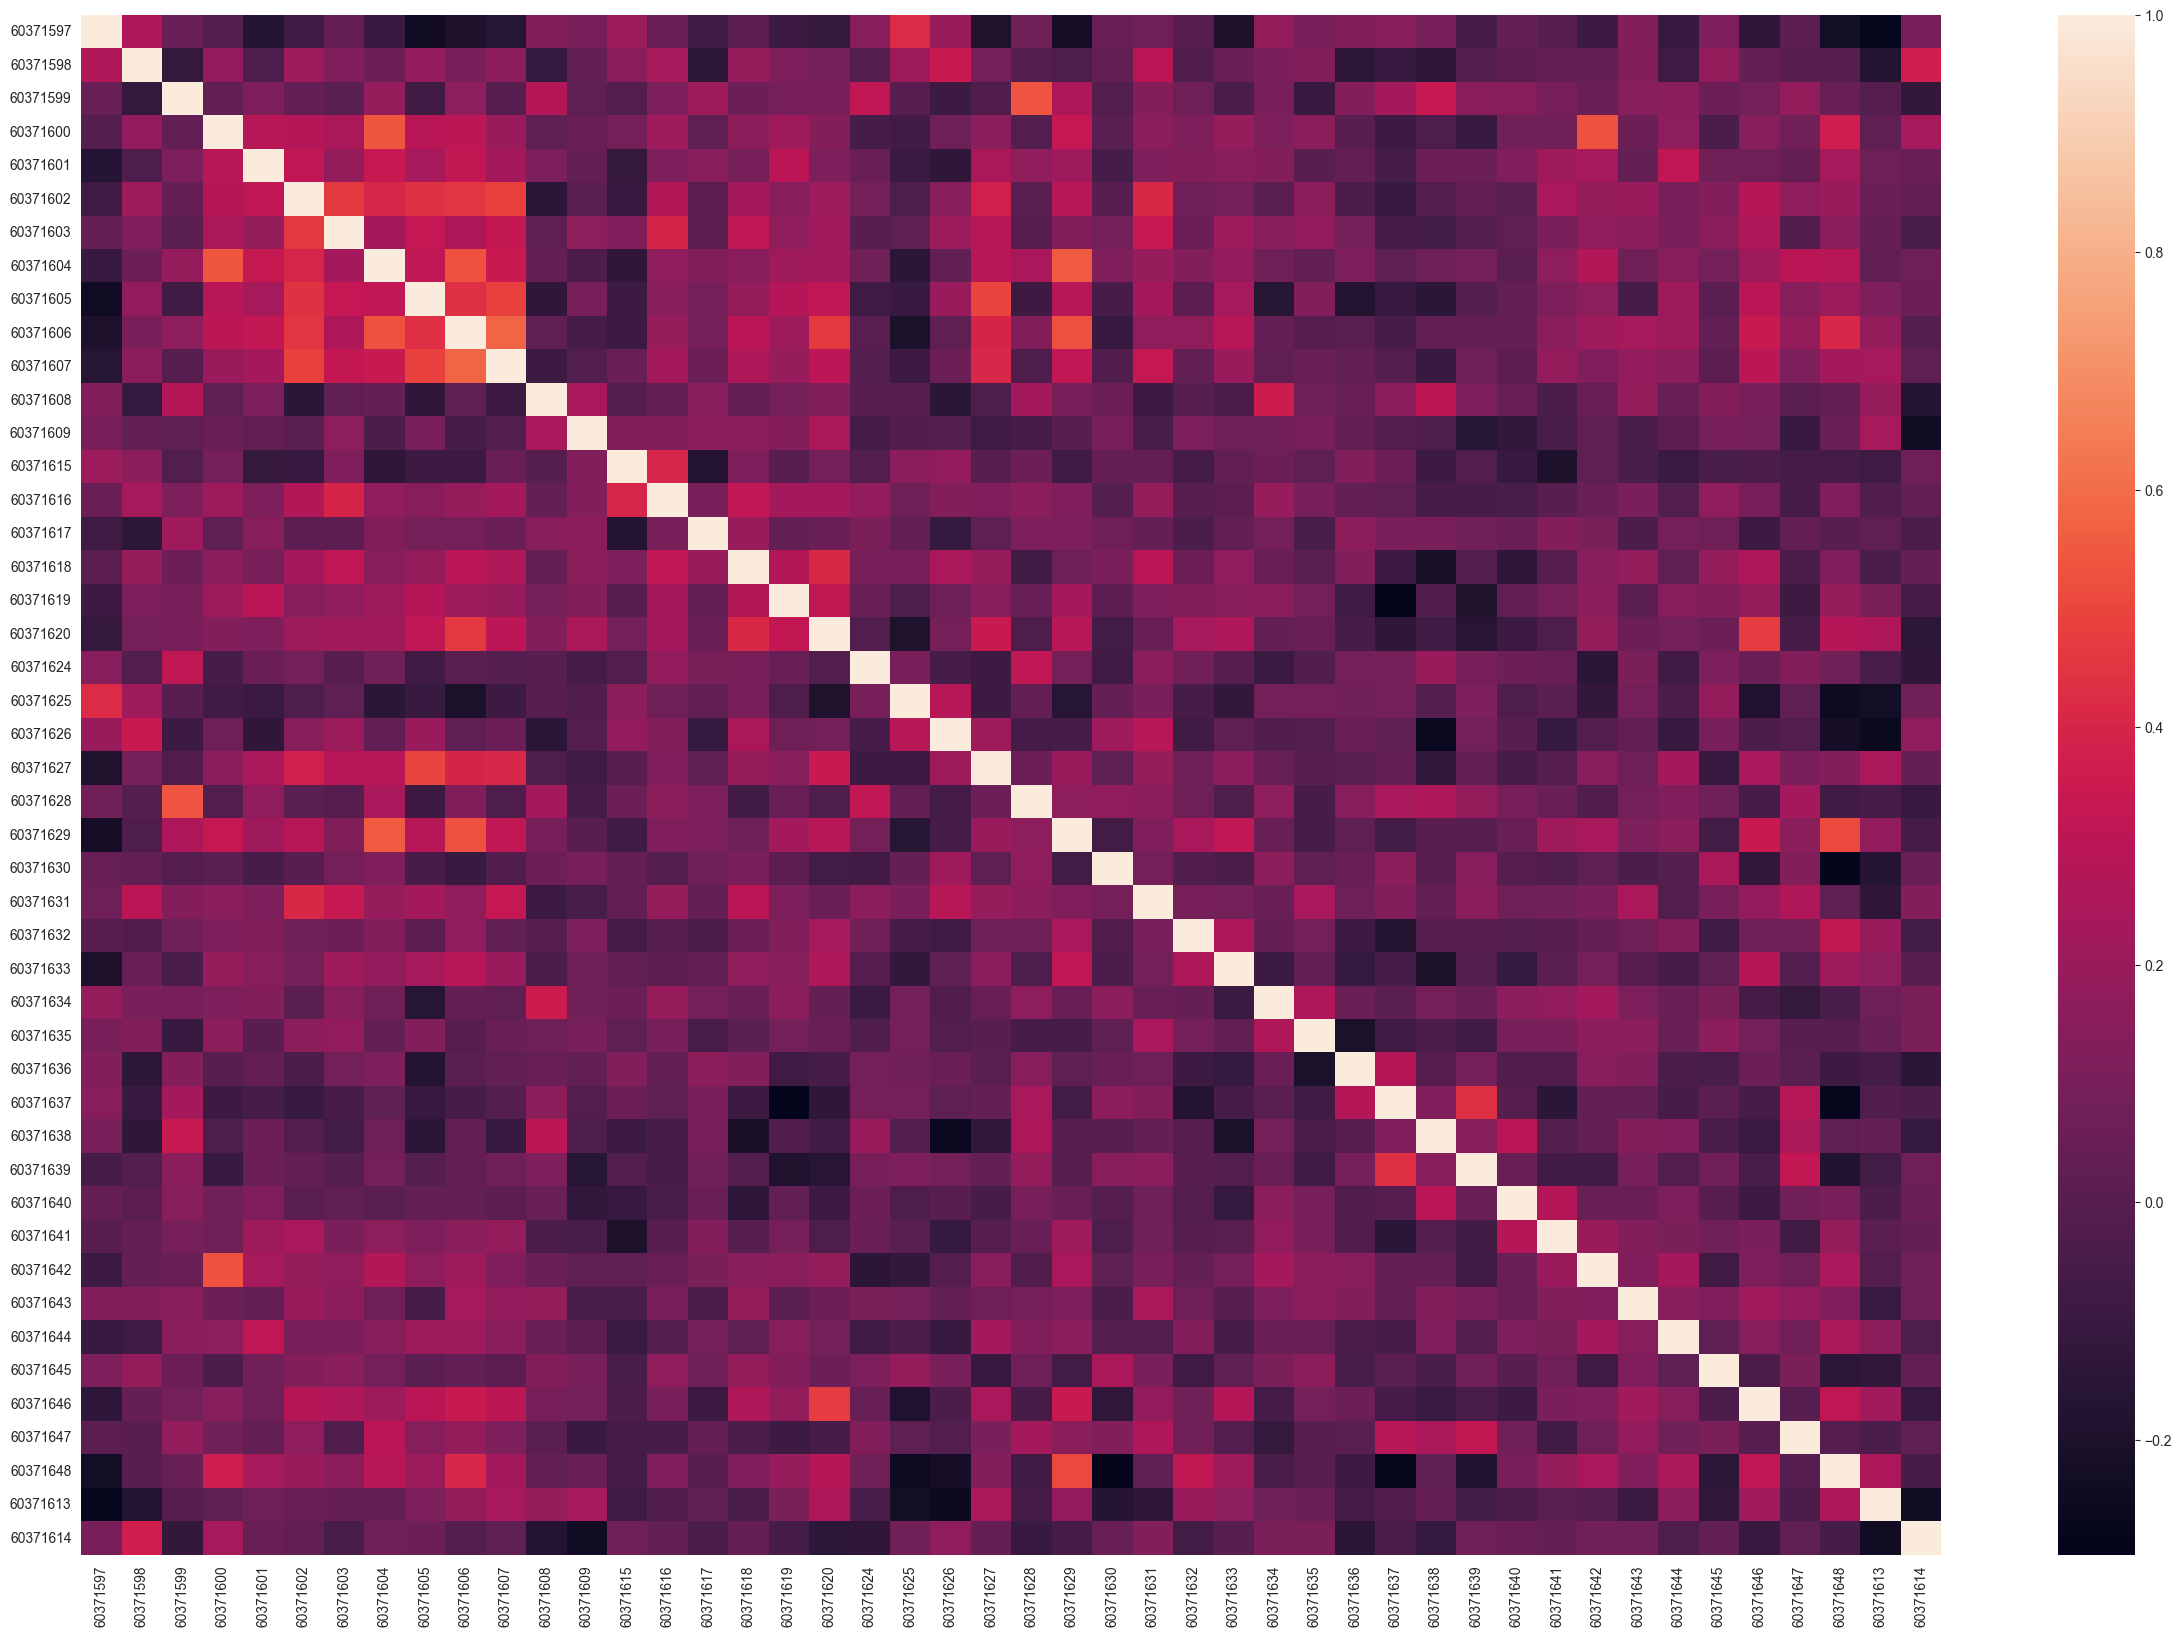

In [357]:
plt.figure(figsize=(30,20))
fig = sns.heatmap(df_results[num_fach_cols].corr())
plt.show(fig)

In [348]:
def plot_hist(col_code: str, col_type: str):
    plt.figure(figsize=(10,5))
    fig = sns.histplot(data=df_results, x=col_code, kde=True, hue=generation_col, element="poly", stat="percent", discrete=True)
    plt.ylabel("Prozent")
    plt.xlabel(get_question_text(col_code))
    legend = fig.get_legend()
    handles = legend.legend_handles
    if col_type == "skala":
        plt.title(f"Wie wichtig ist dir... {get_question_text(col_code)}")
    else:
        plt.title(f"Ergebnisse... {get_question_text(col_code)}")
    if col_type == 'one_to_n':
        fig.set_xticks(sorted(df_results[col_code].unique())) # <--- set the ticks first
        fig.set_xticklabels([get_answer_text(col_code, x) for x in sorted(df_results[col_code].unique())], rotation=90)
    plt.legend(handles, [get_answer_text(generation_col, x) for x in sorted(df_results[generation_col].unique())])
    plt.show(fig)

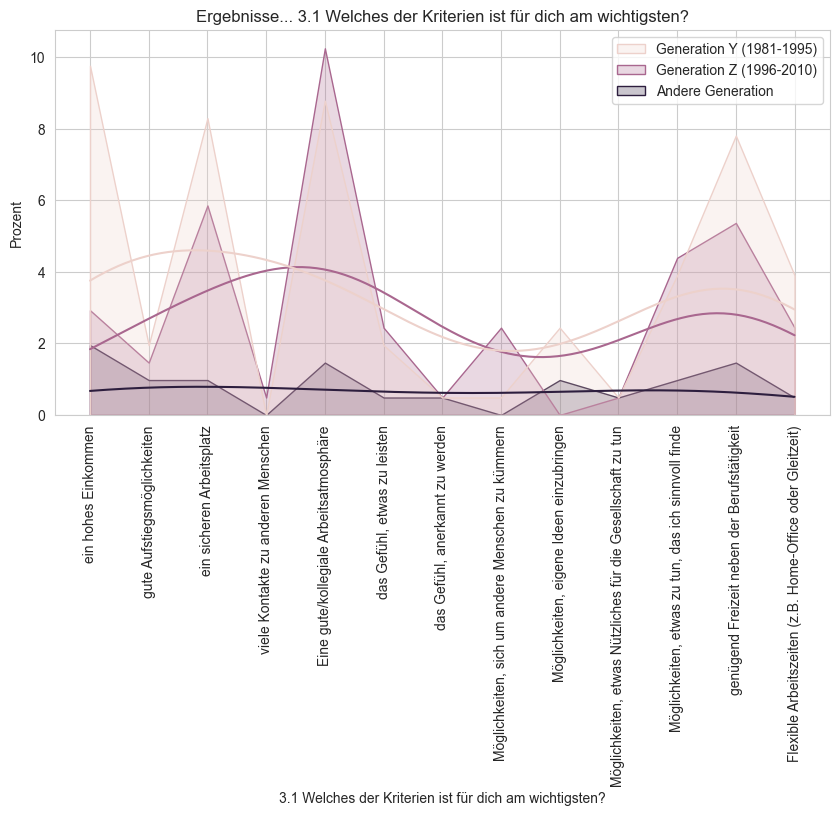

In [349]:
plot_hist('60371613', "one_to_n")

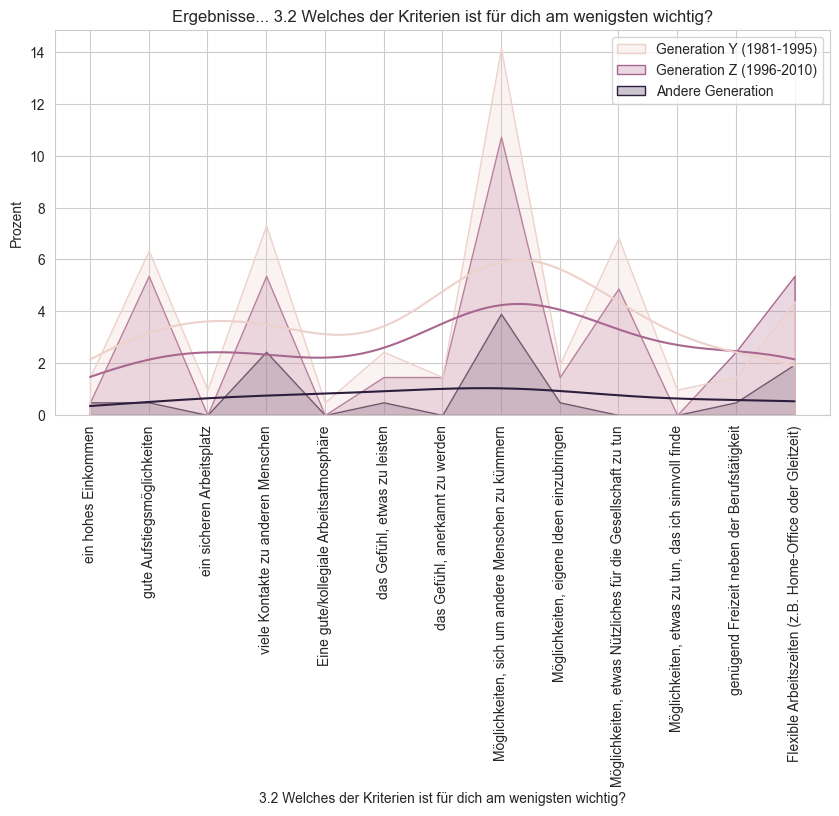

In [350]:
plot_hist('60371614', "one_to_n")

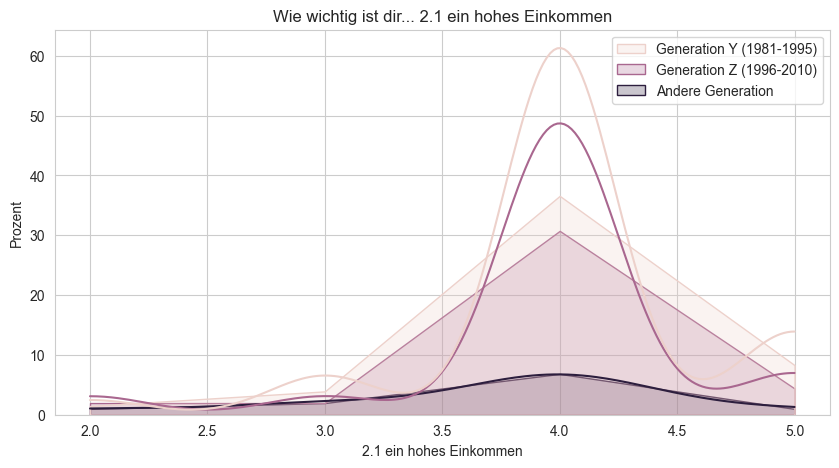

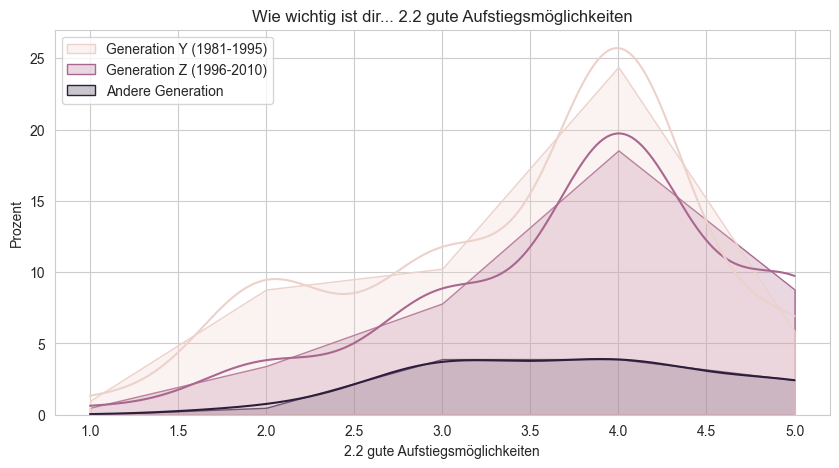

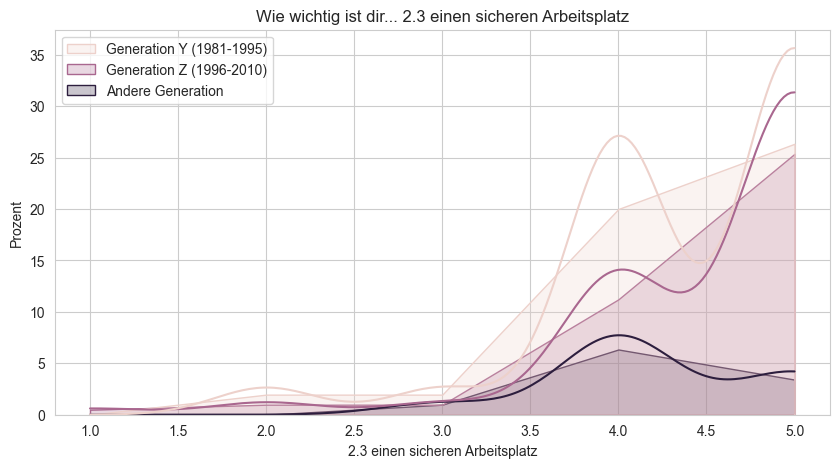

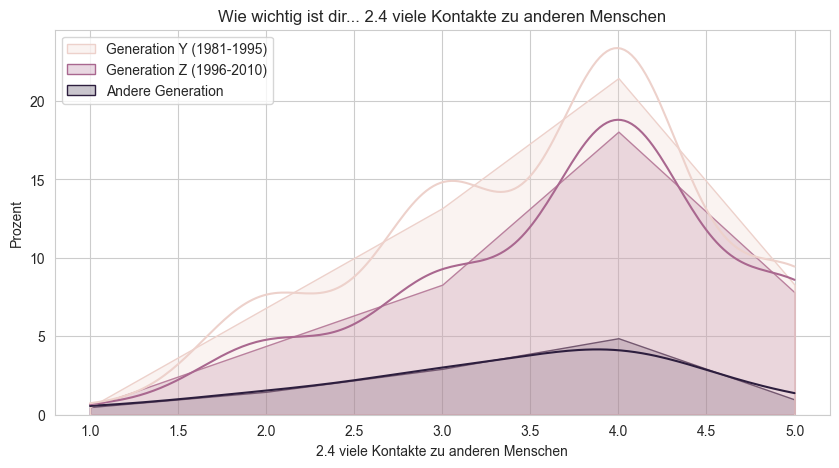

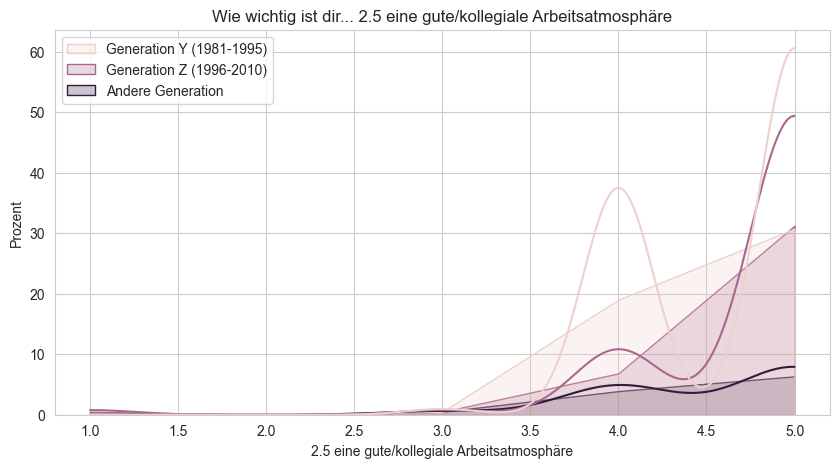

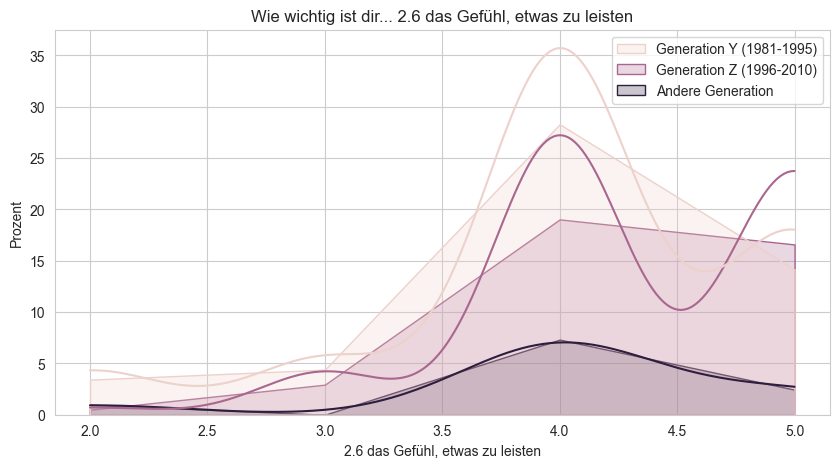

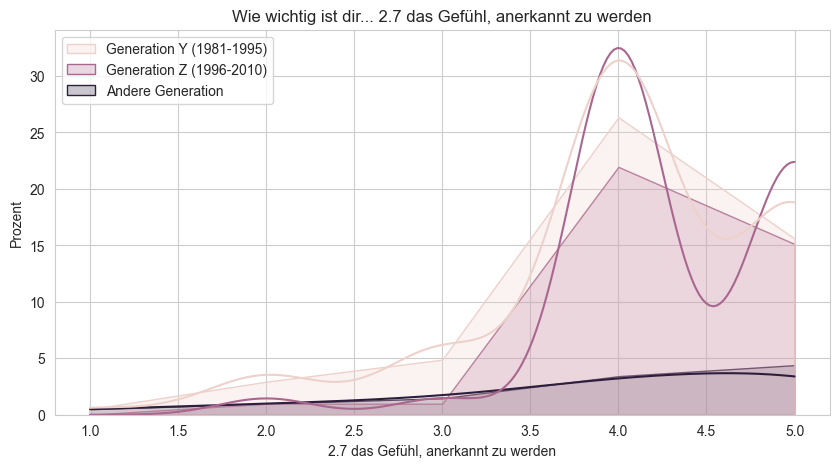

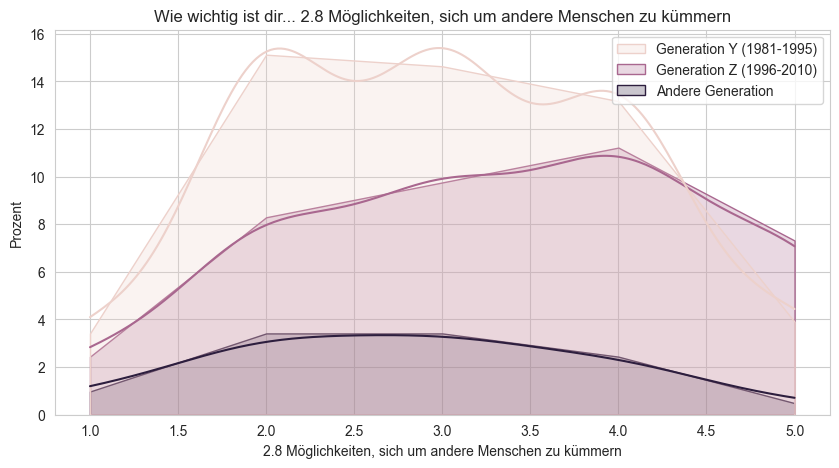

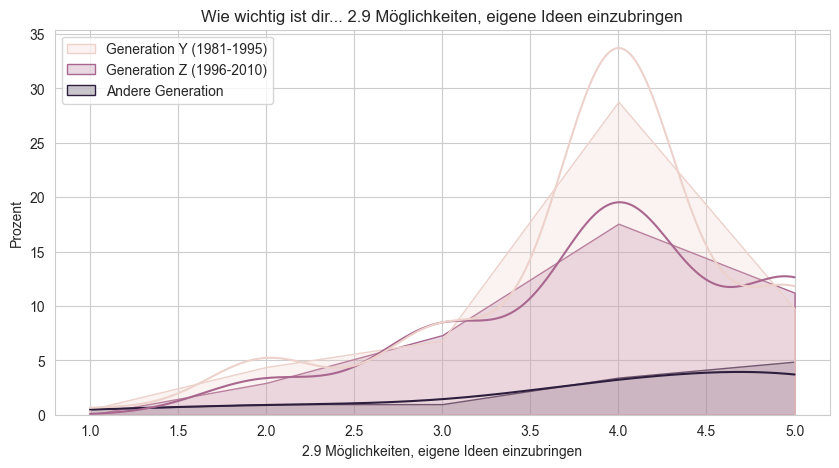

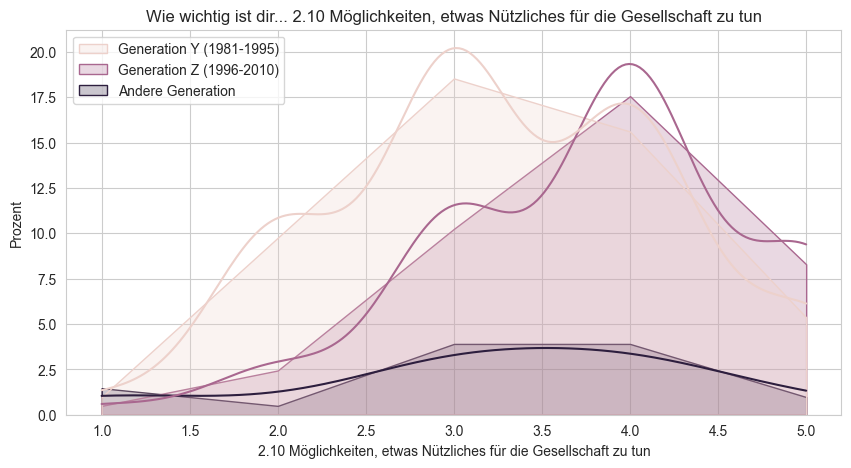

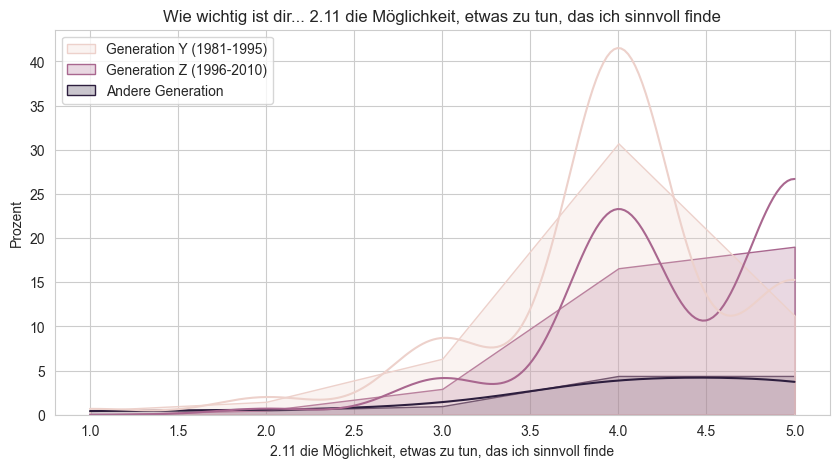

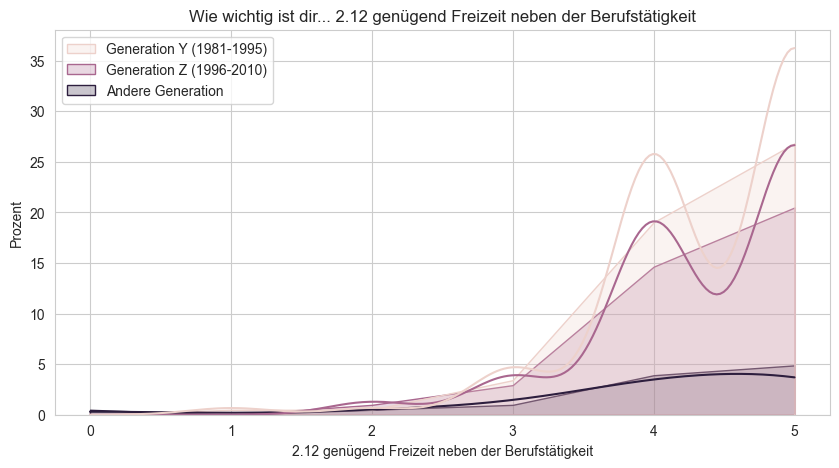

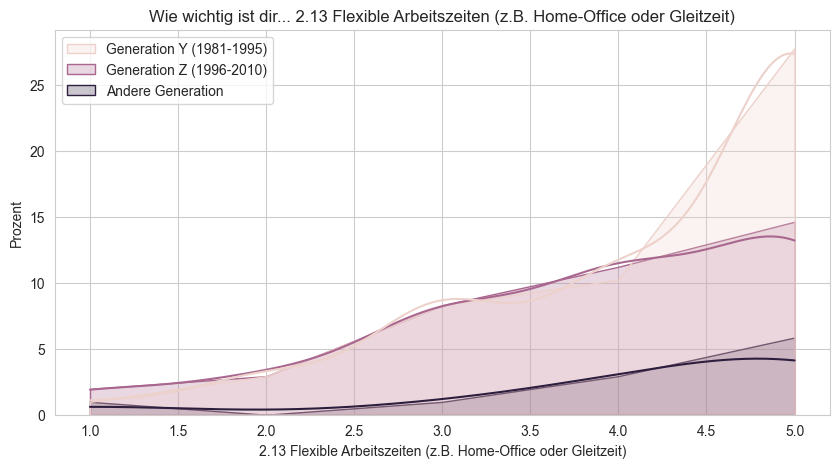

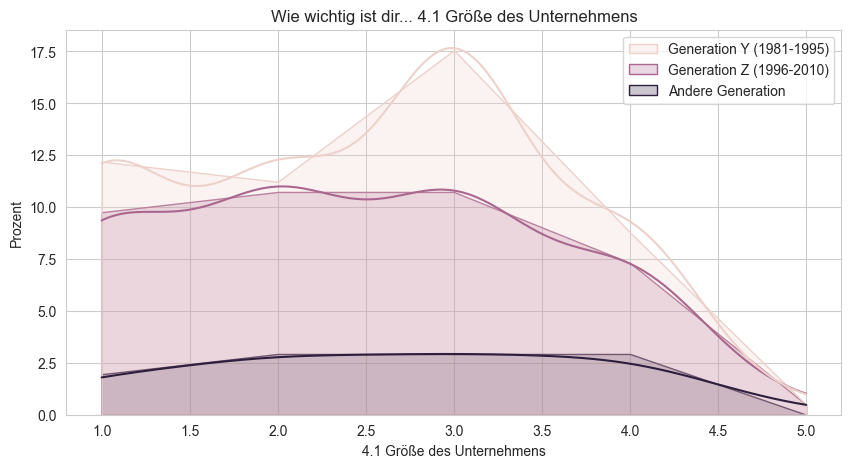

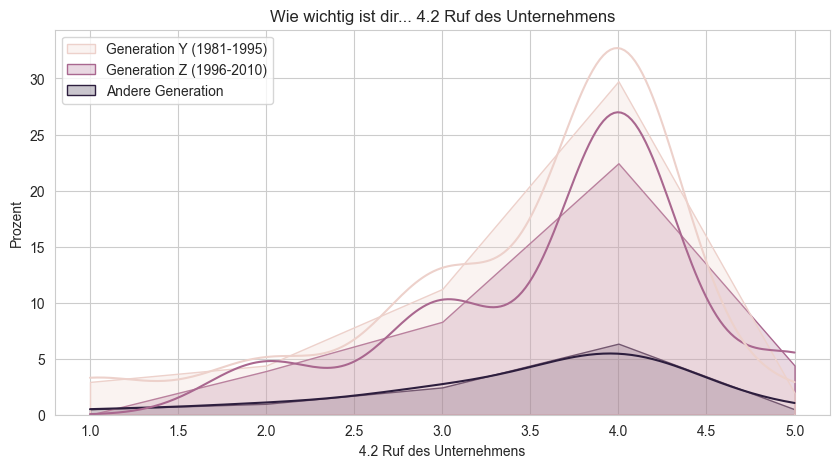

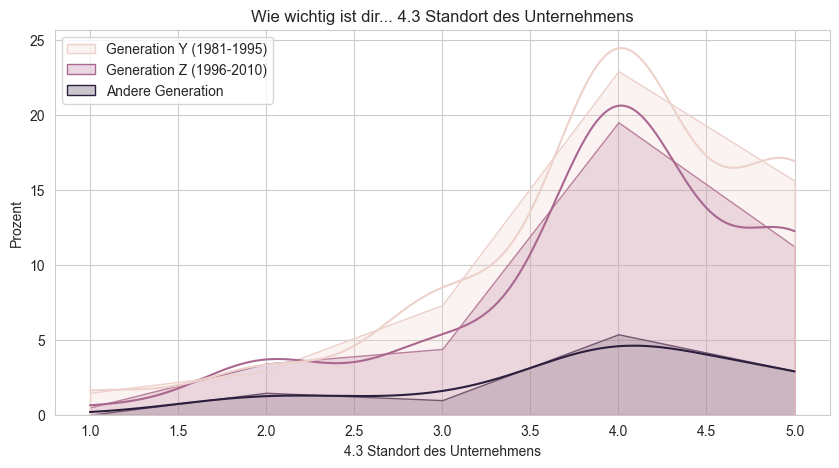

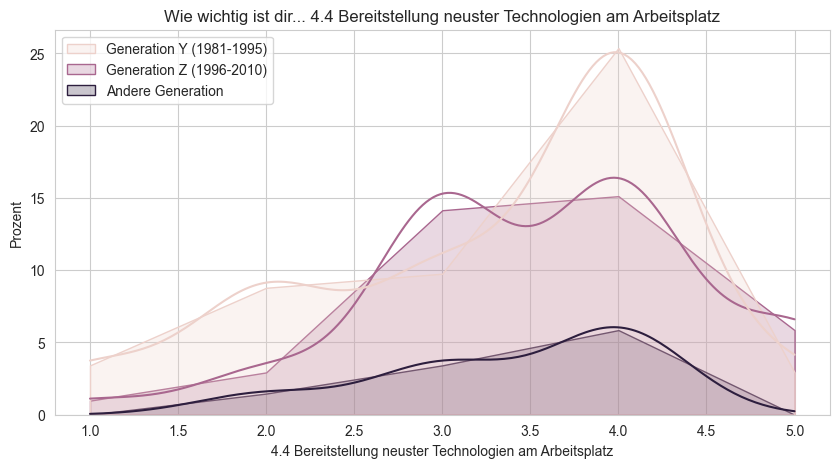

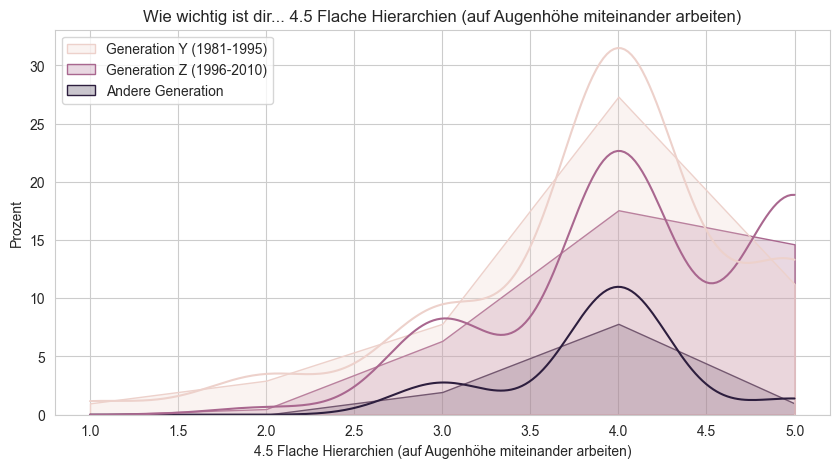

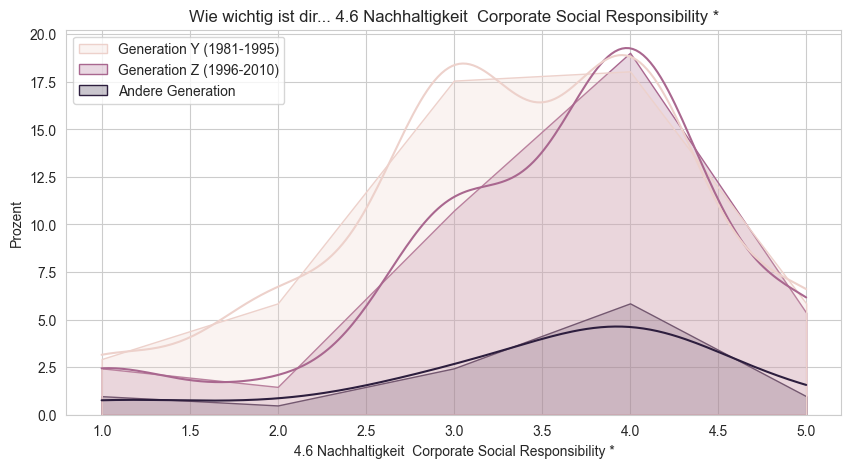

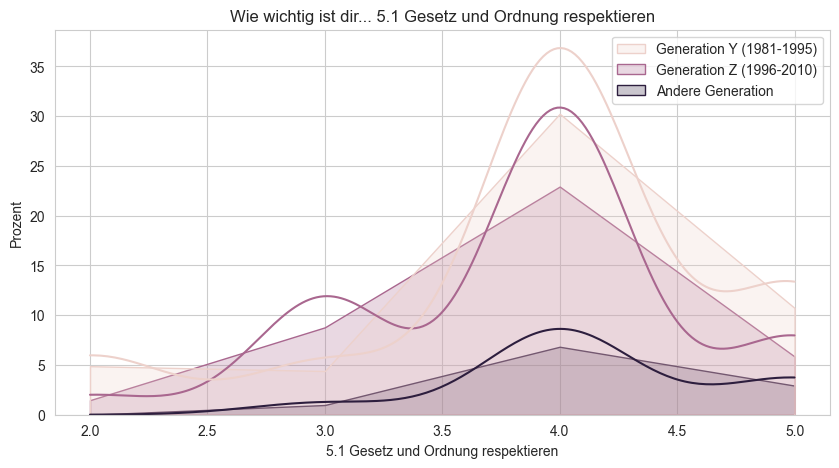

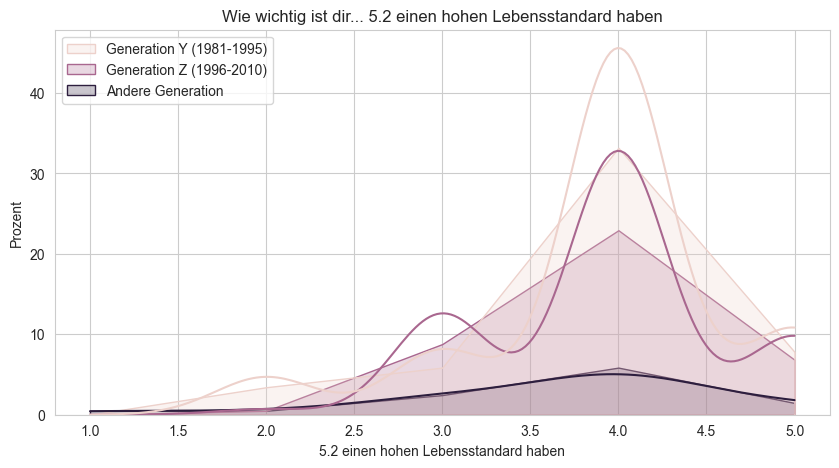

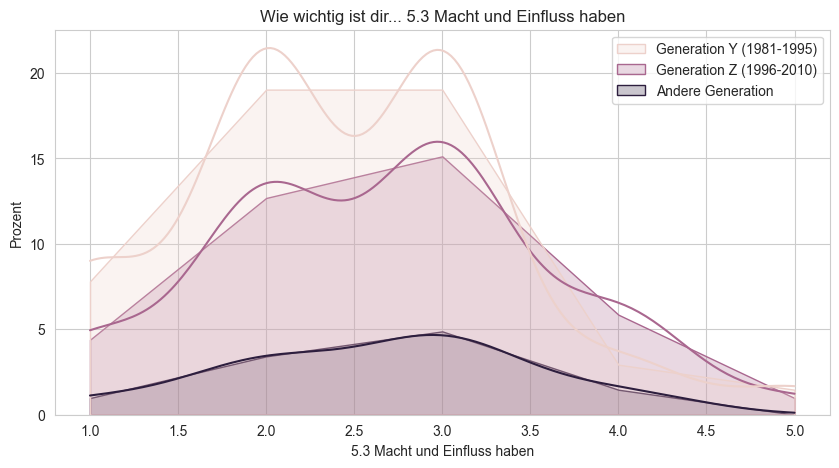

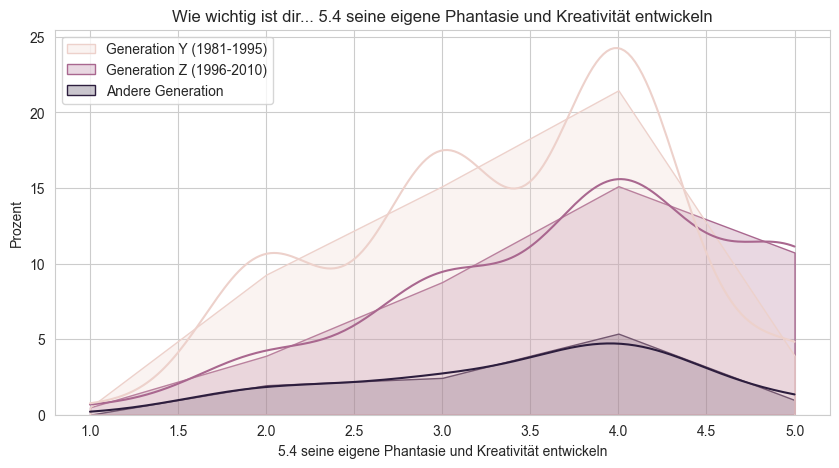

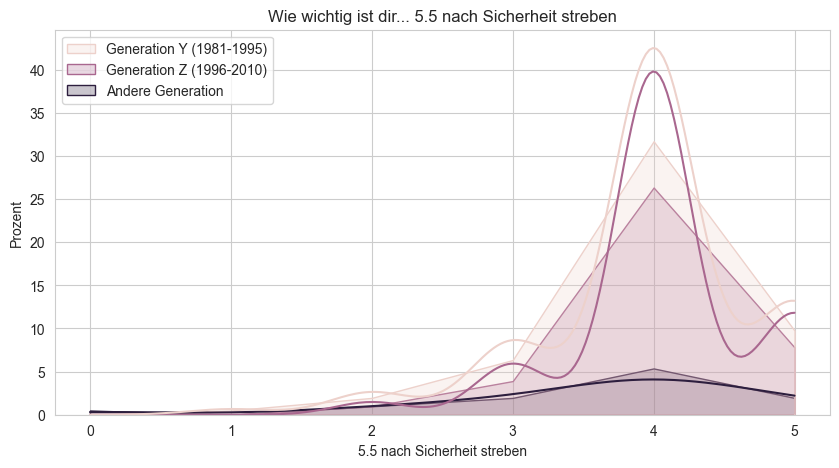

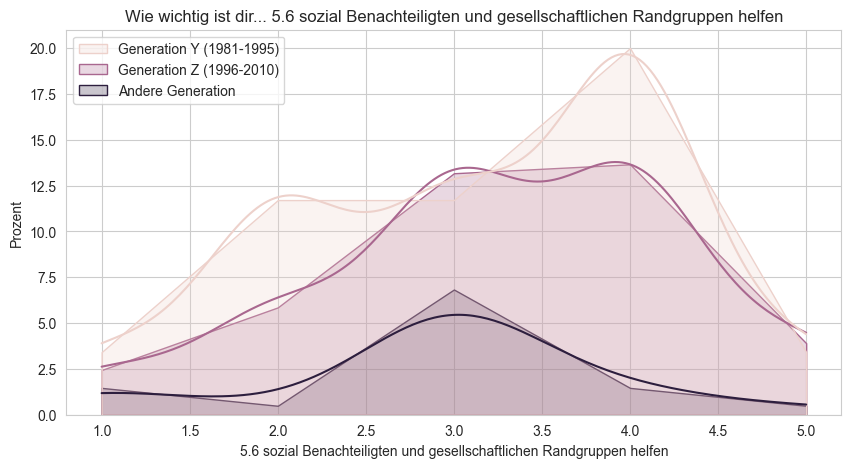

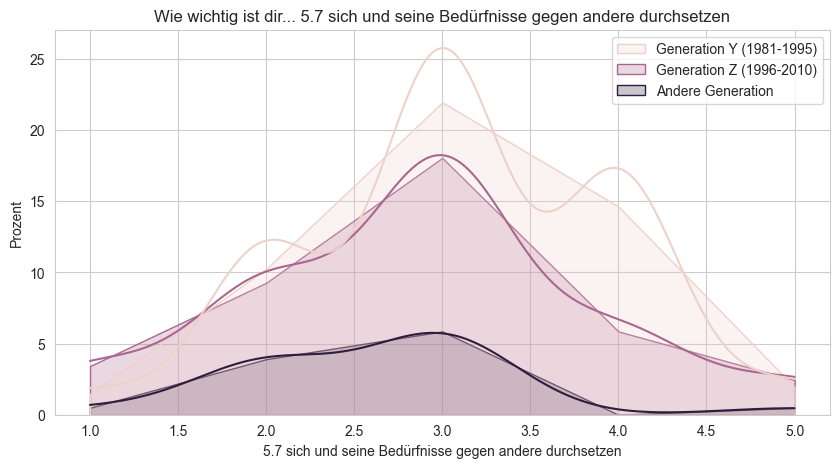

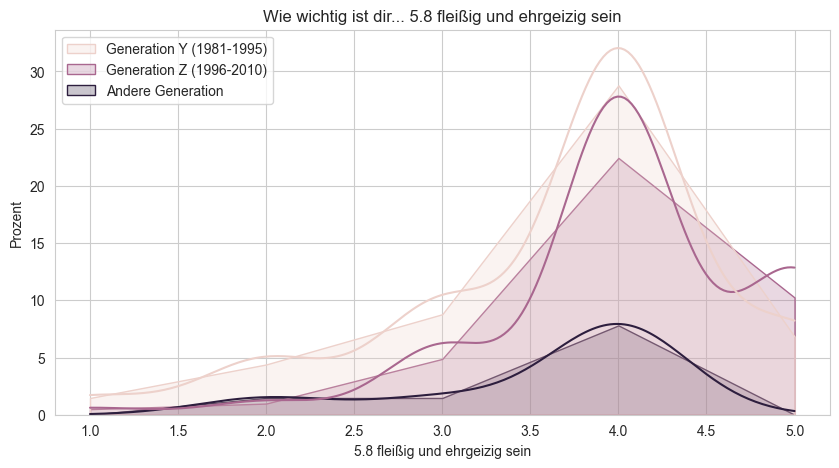

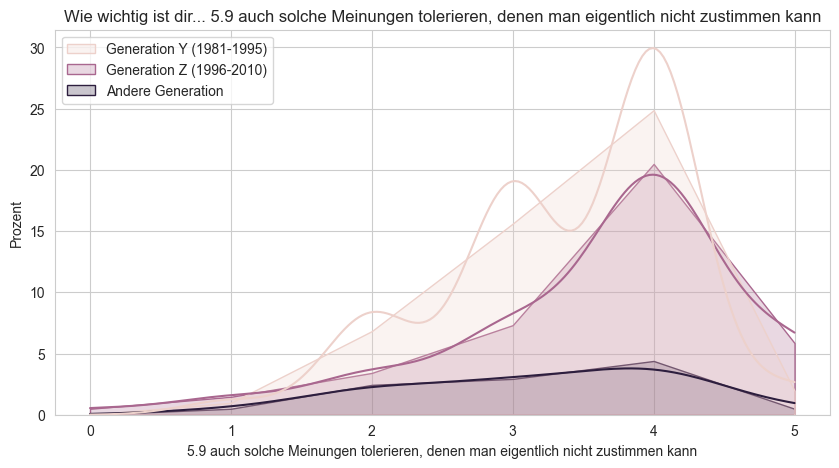

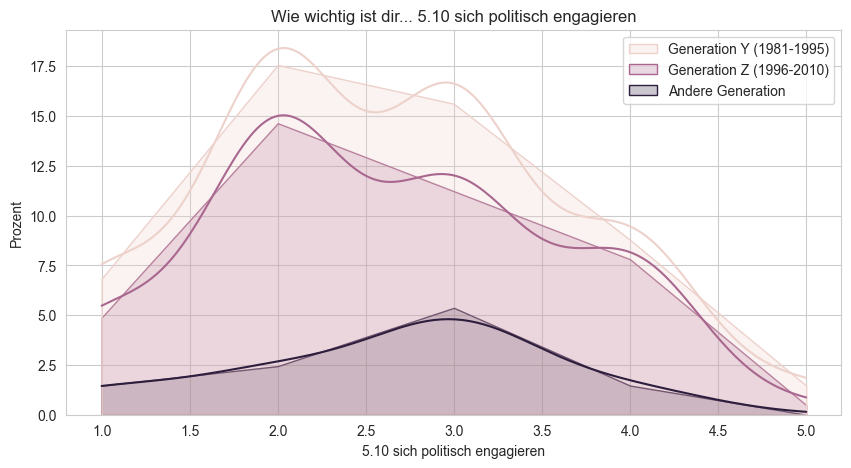

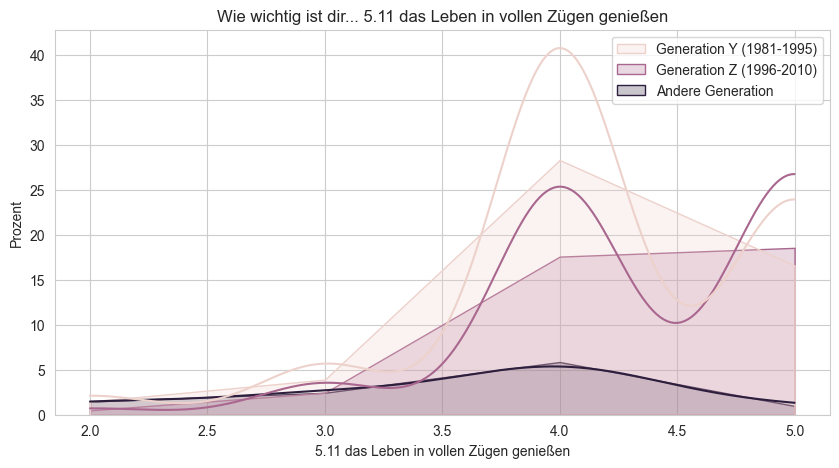

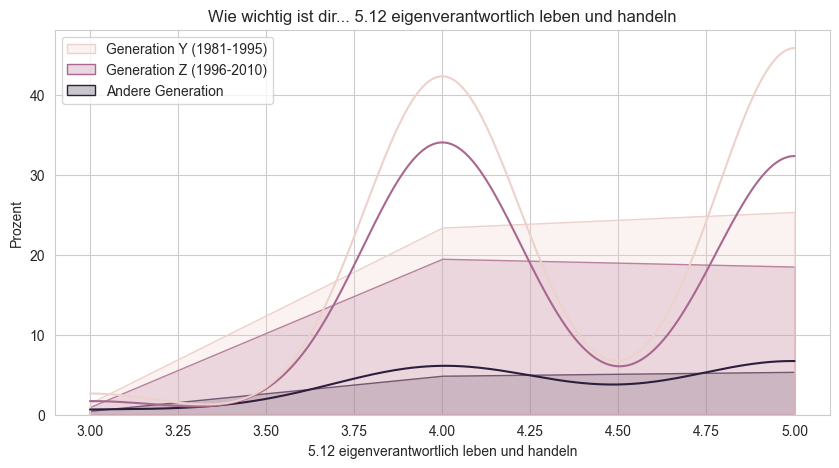

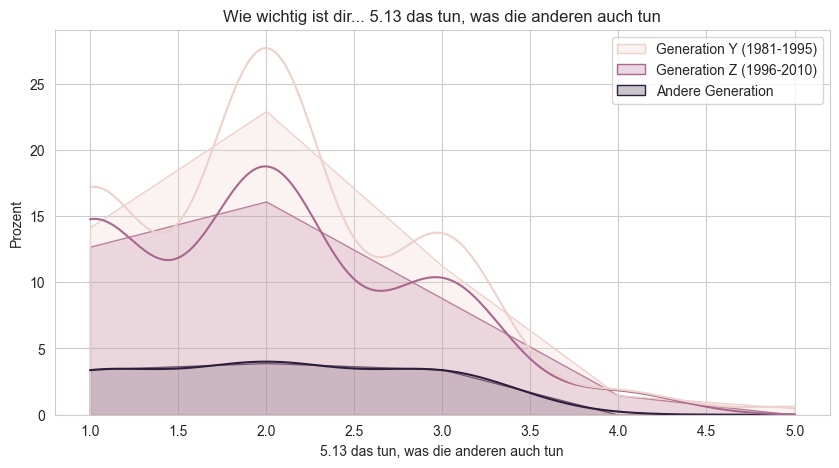

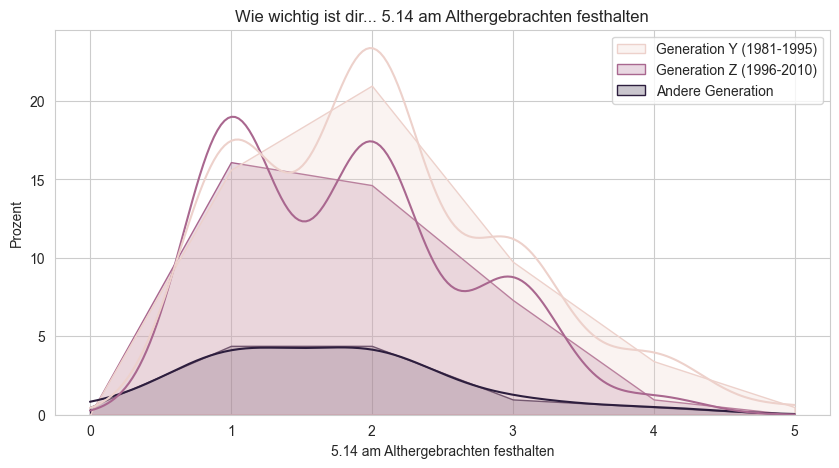

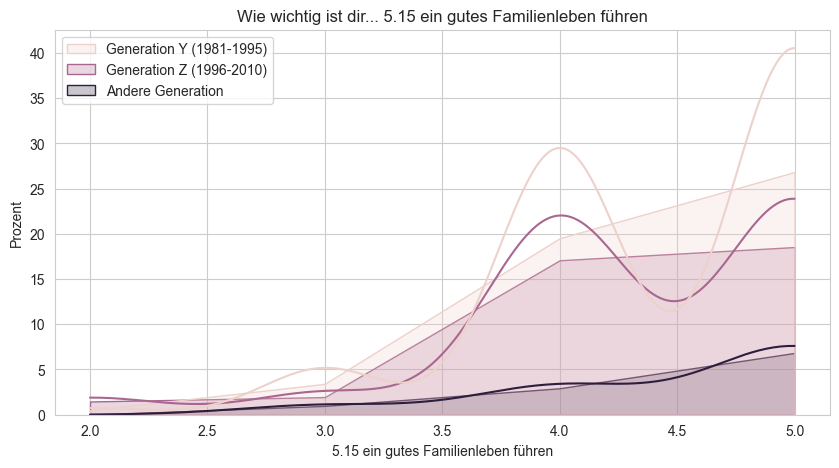

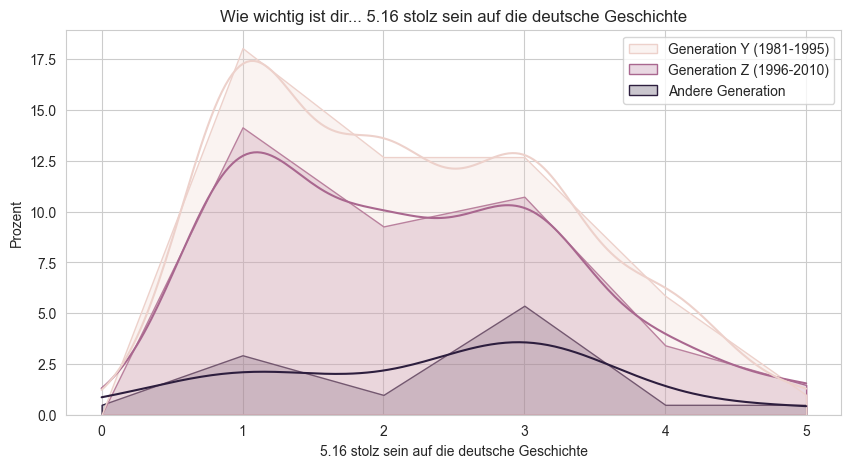

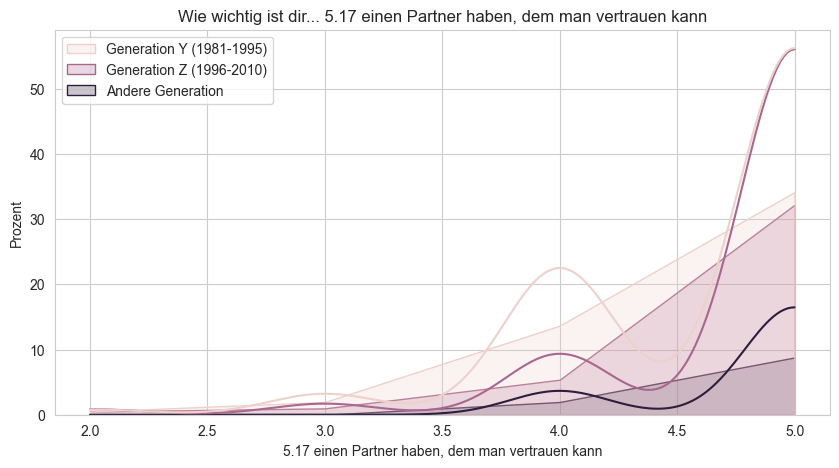

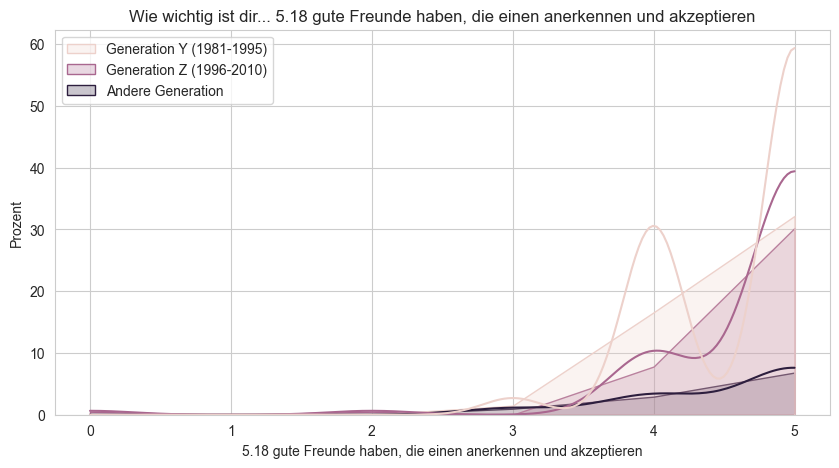

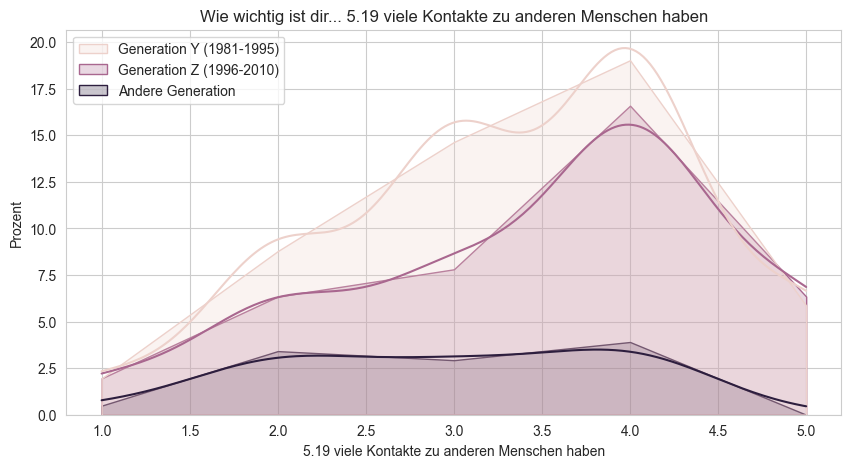

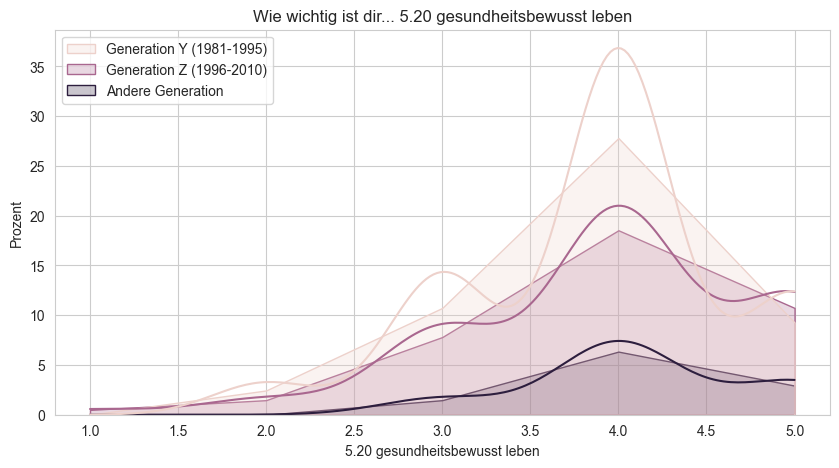

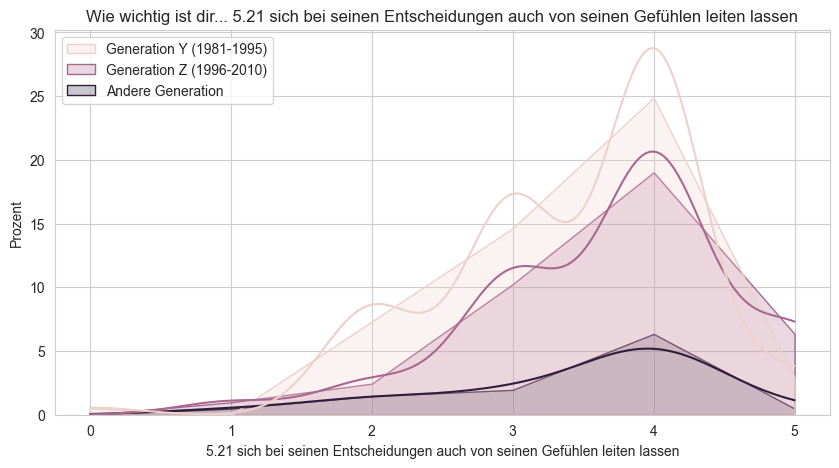

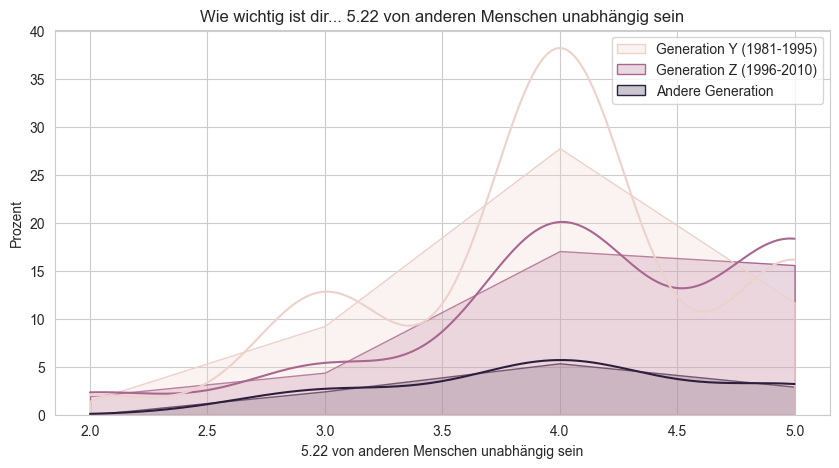

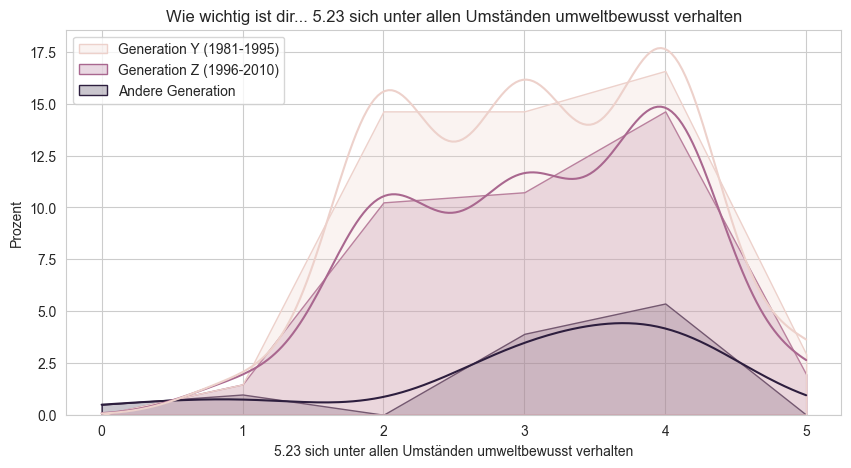

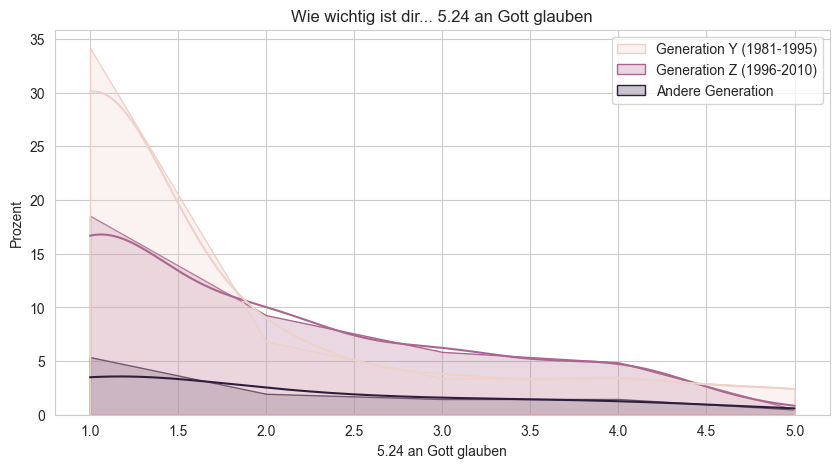

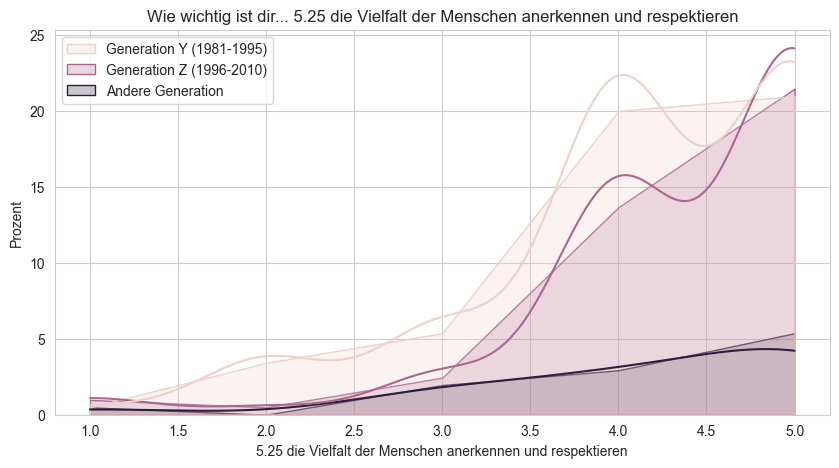

In [330]:
for col in skala_fach_ids:
    plot_hist(col, "skala")

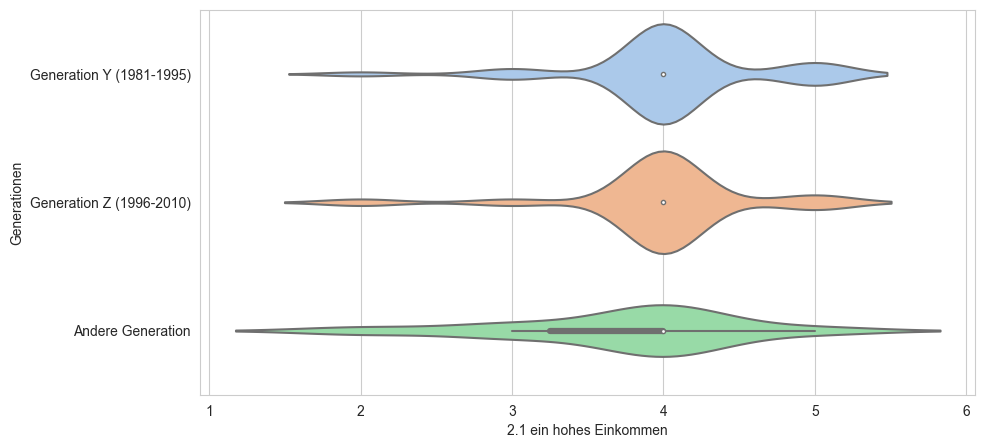

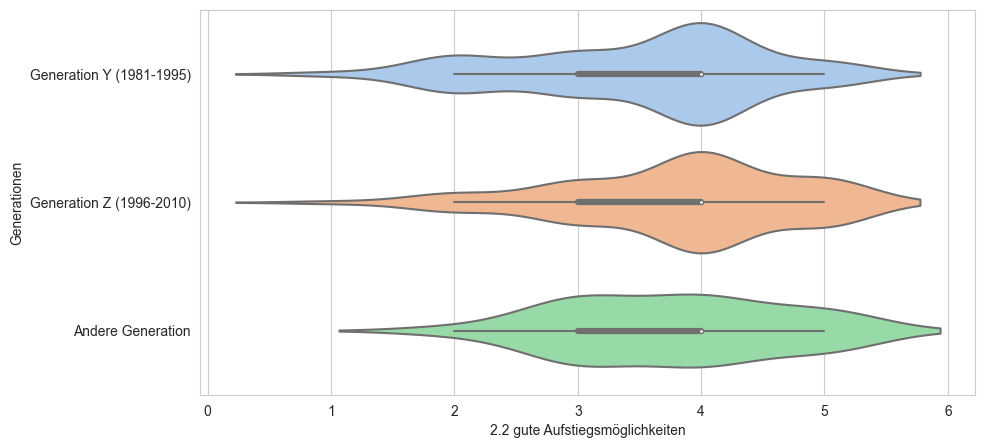

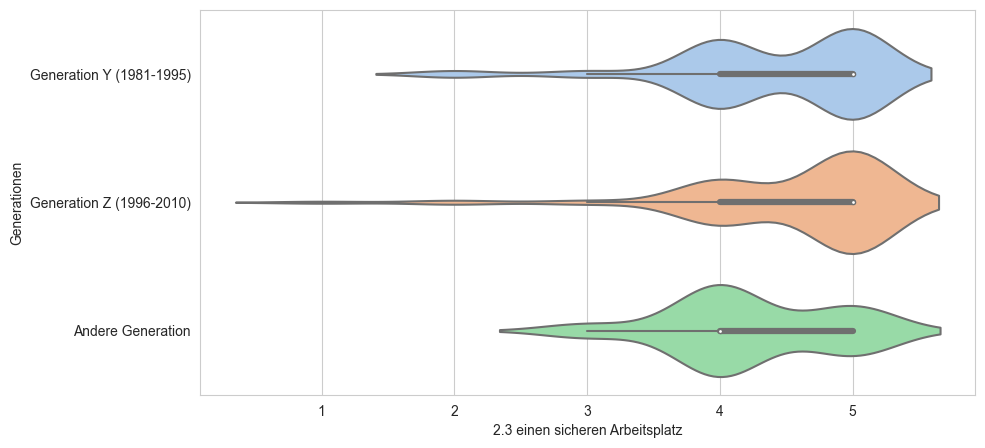

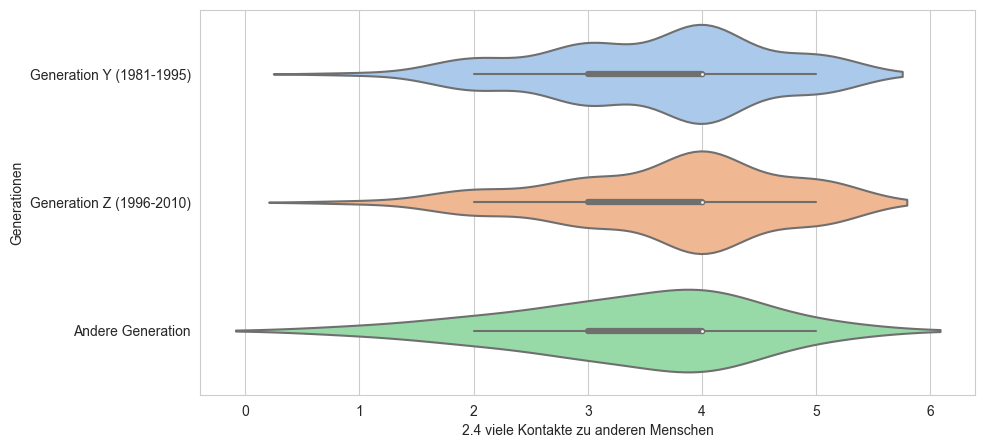

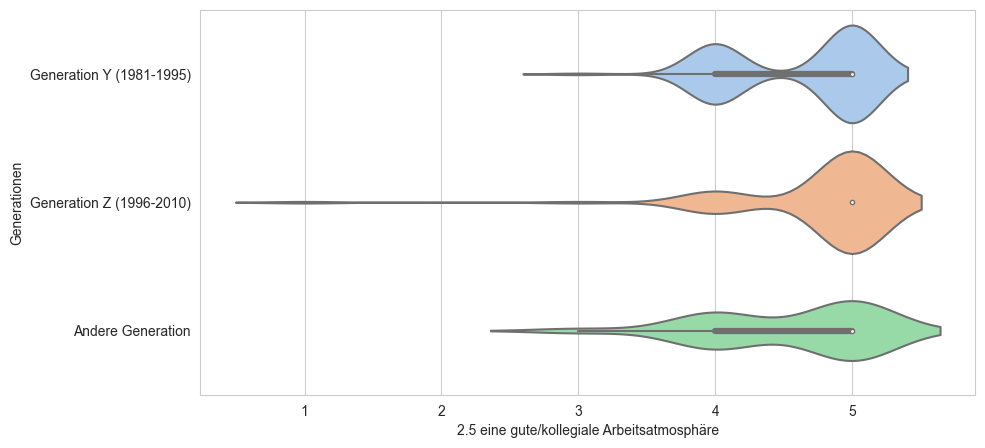

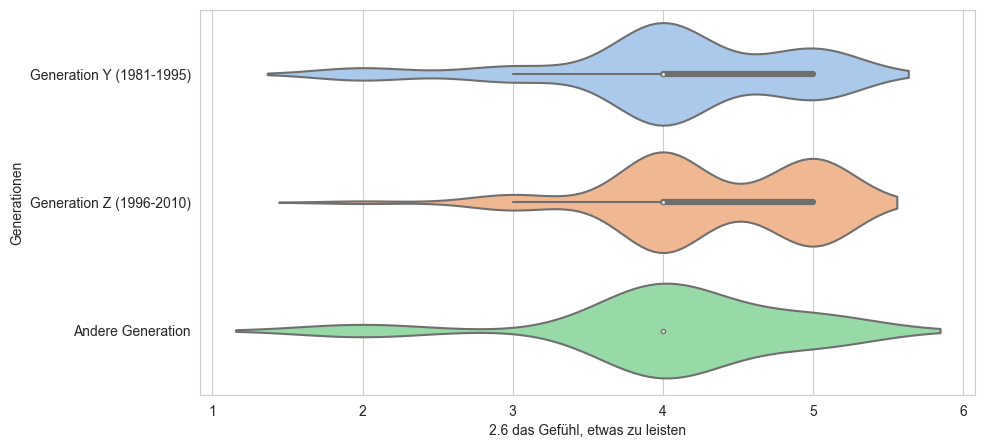

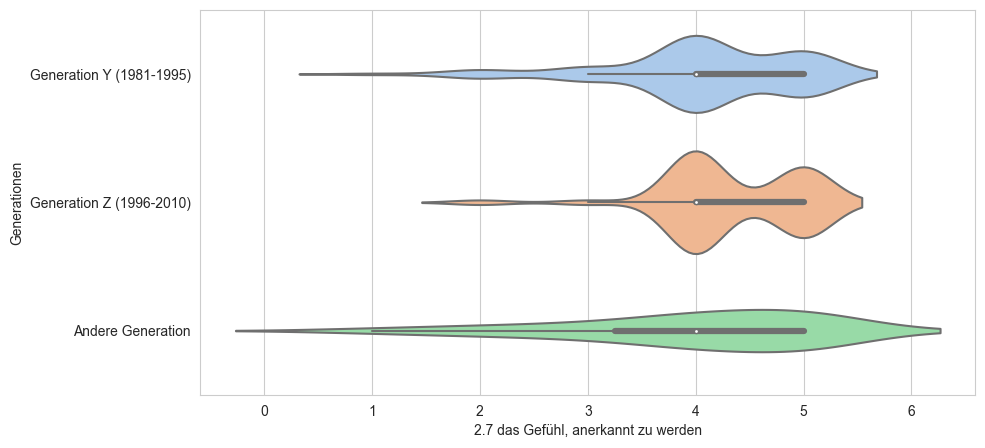

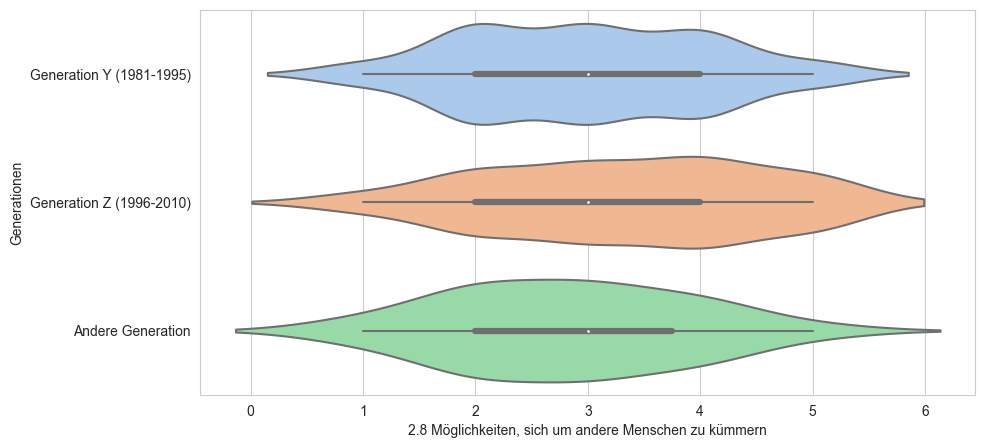

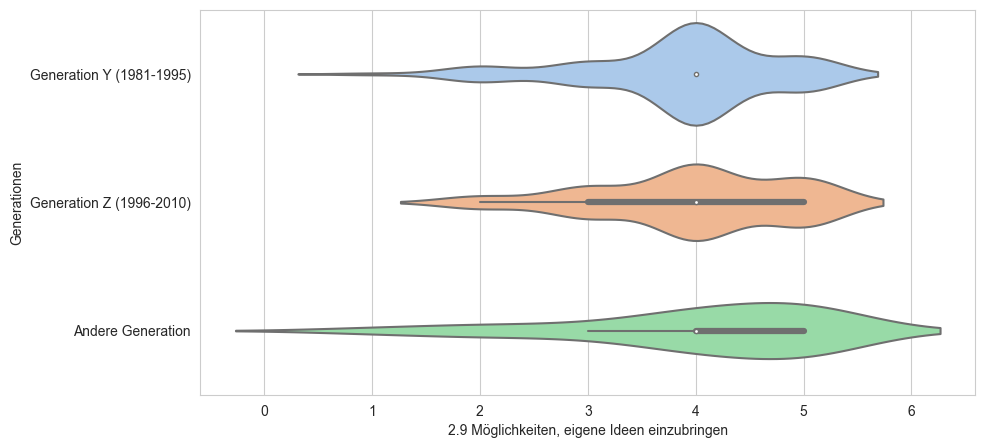

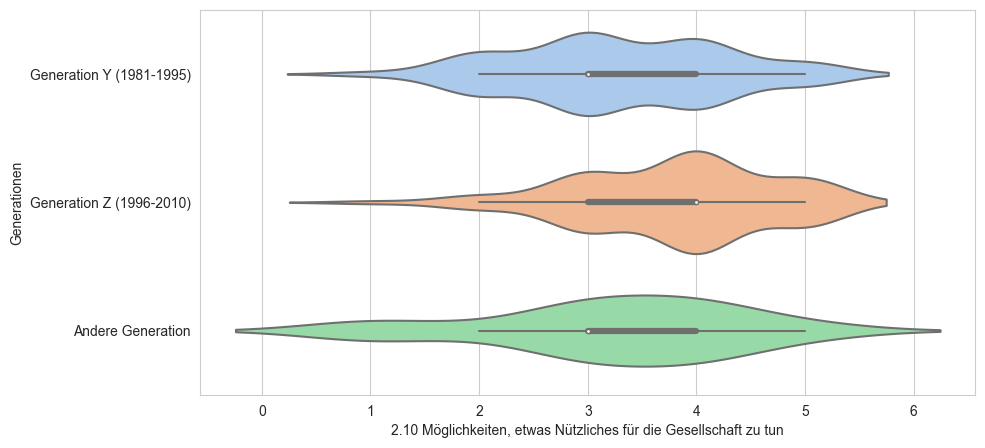

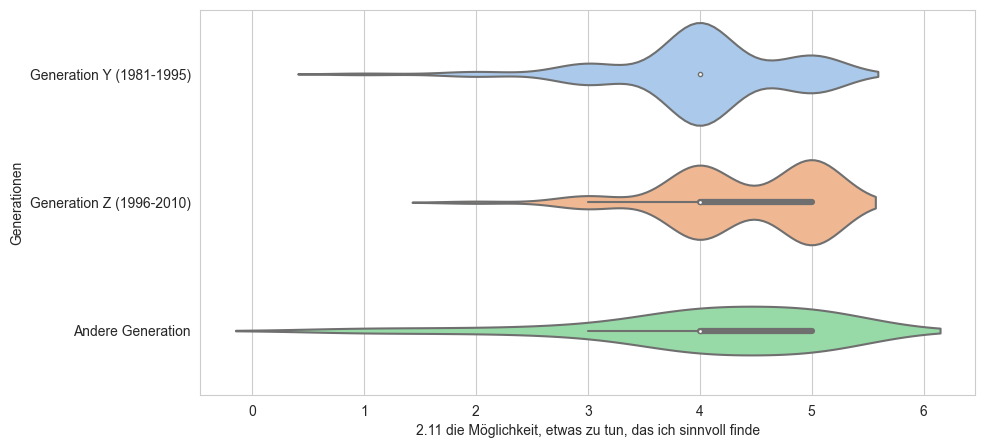

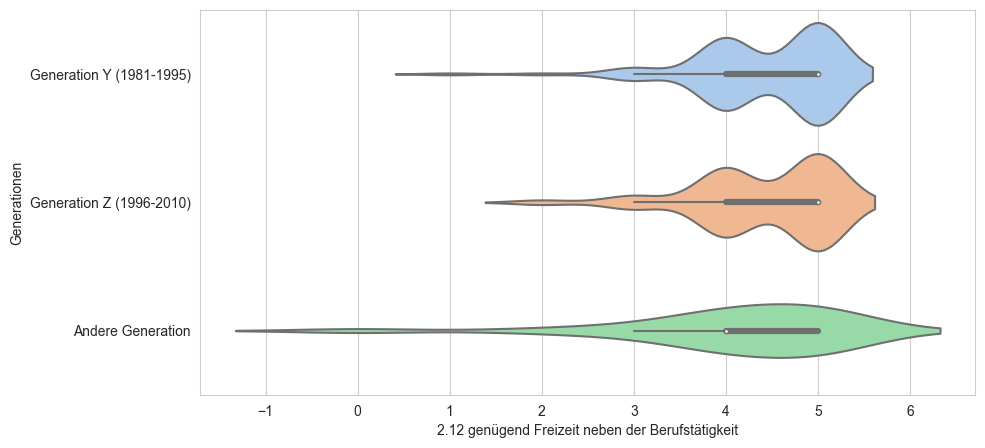

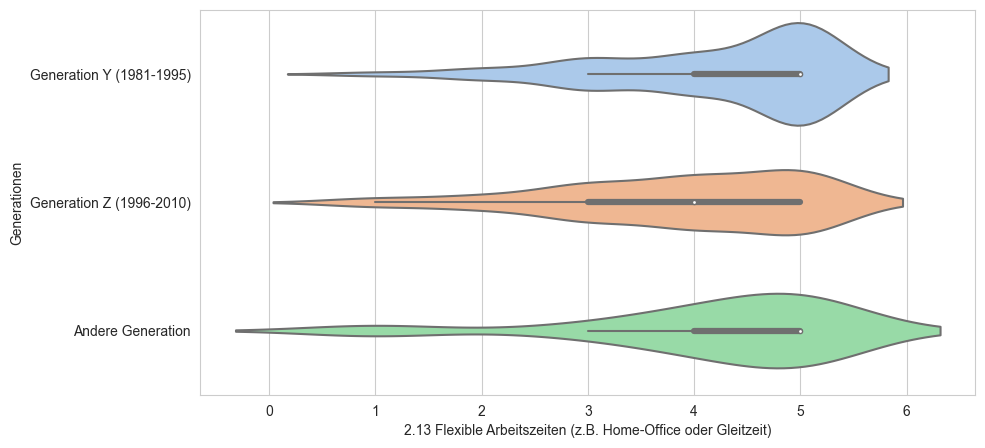

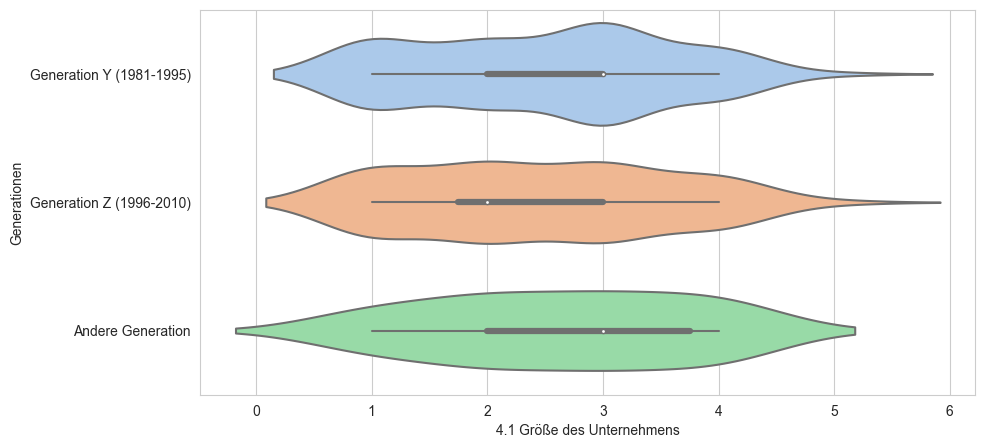

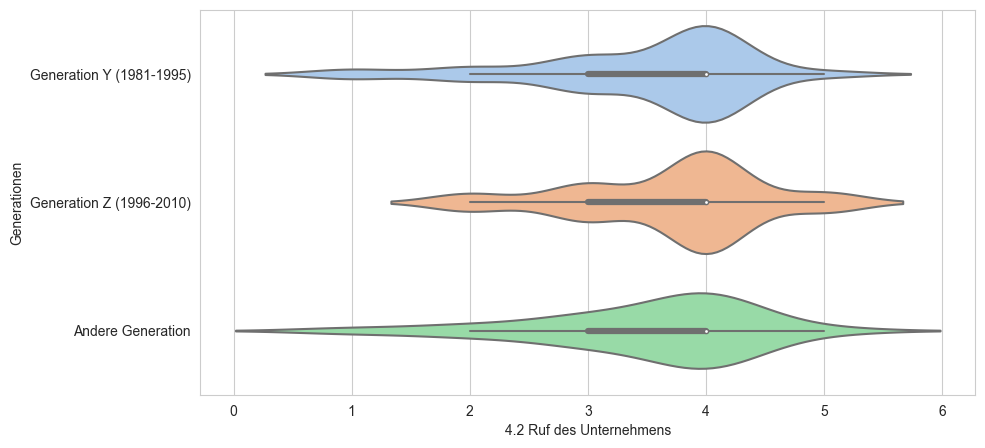

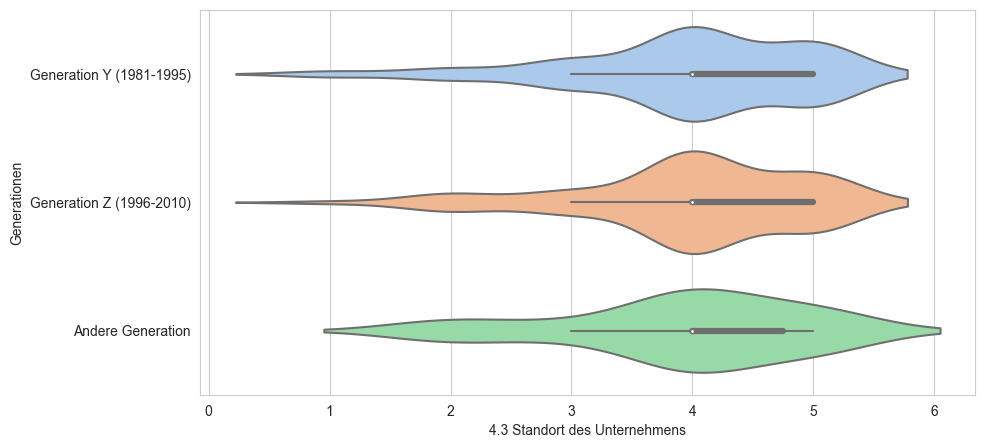

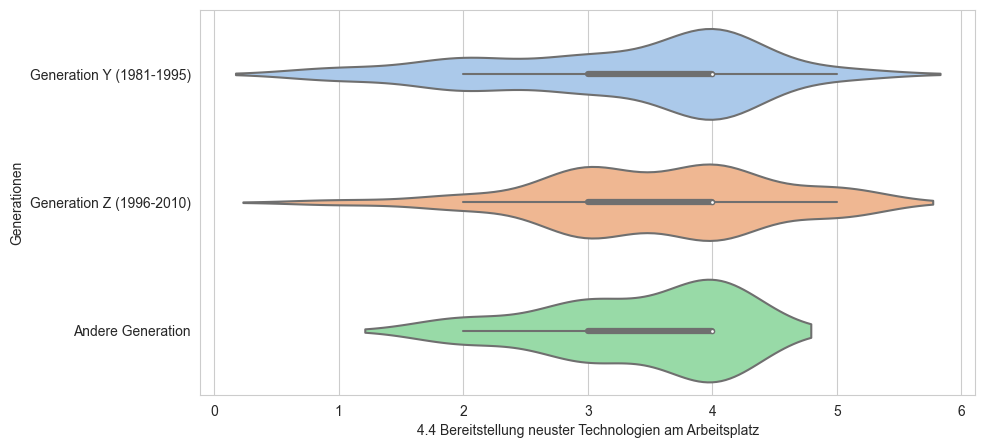

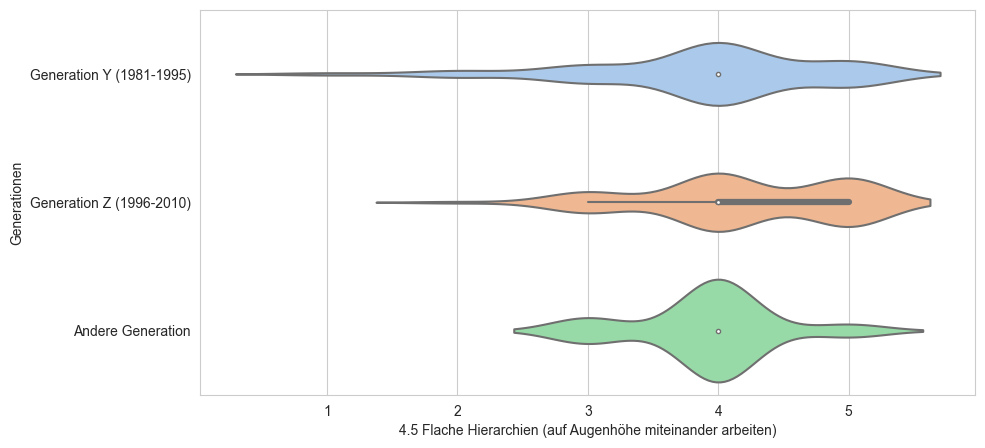

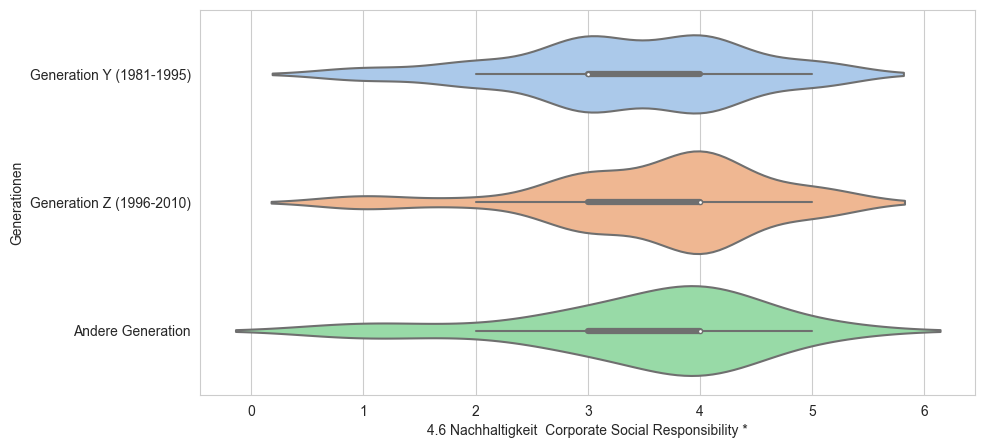

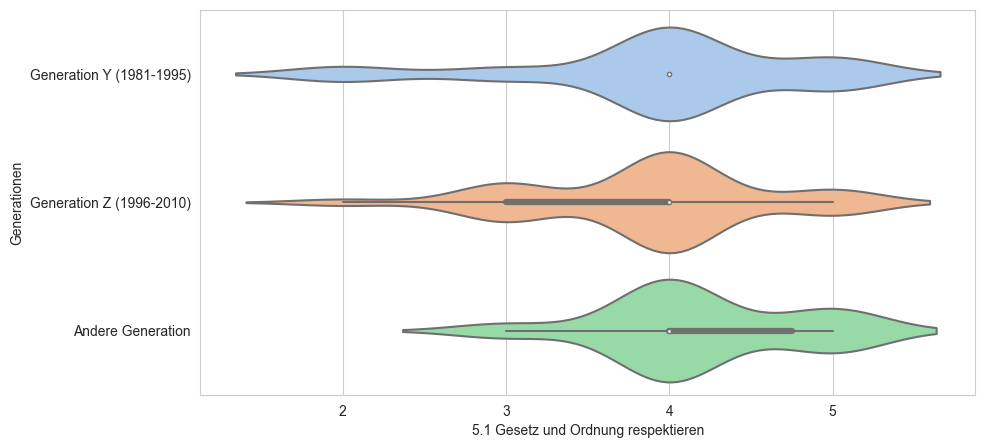

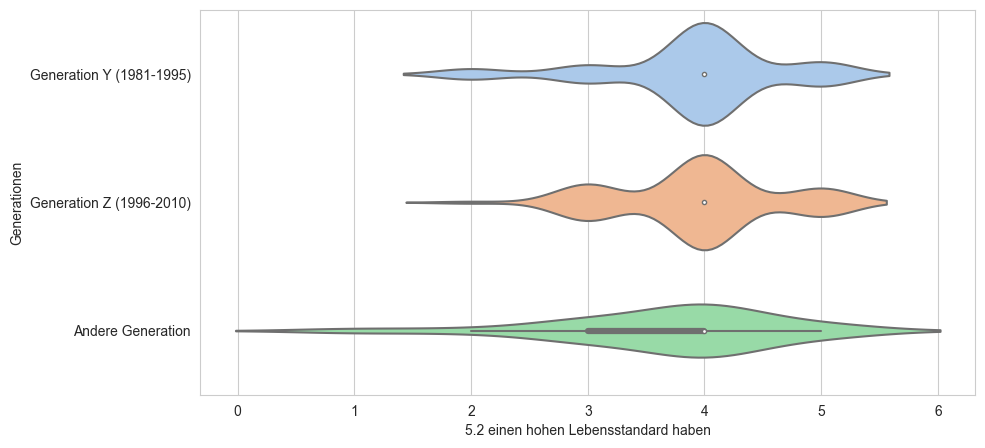

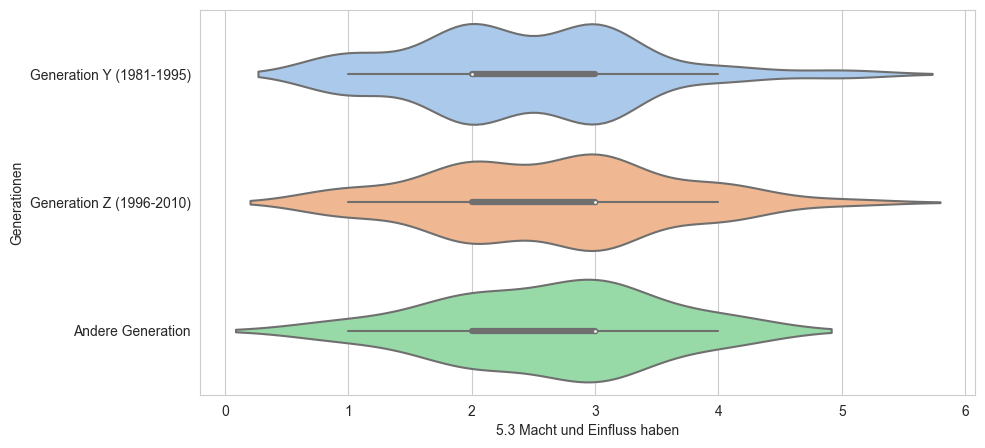

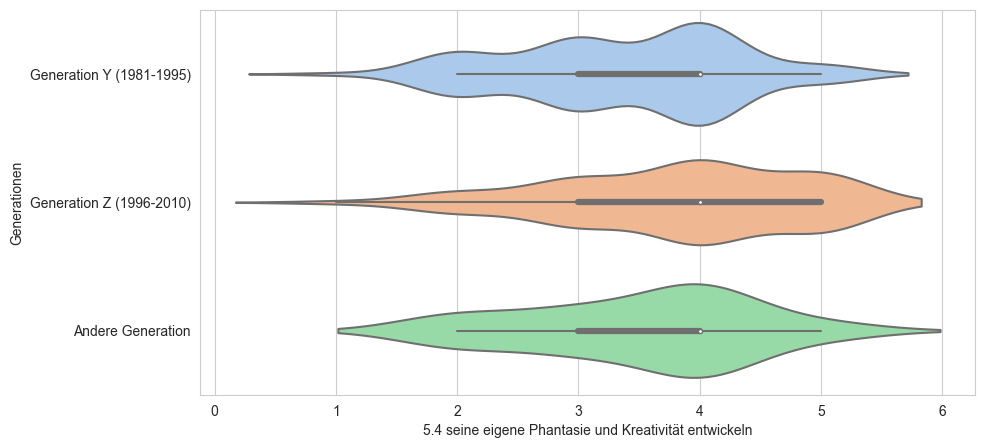

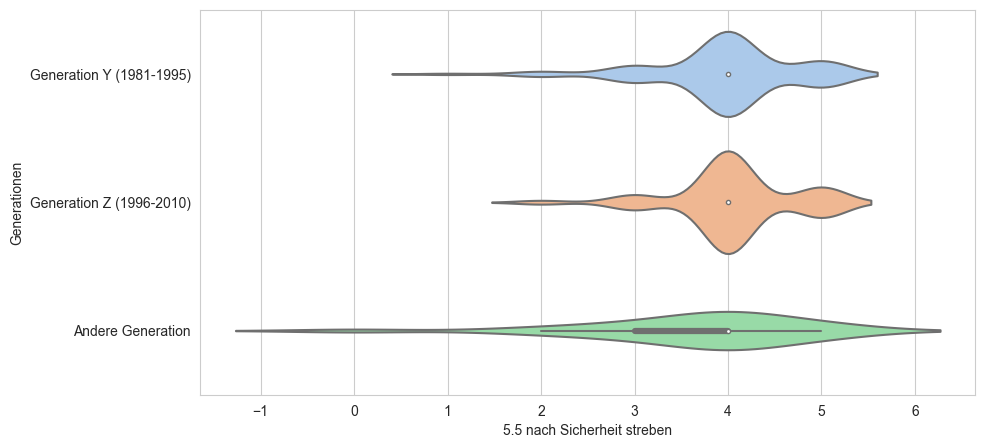

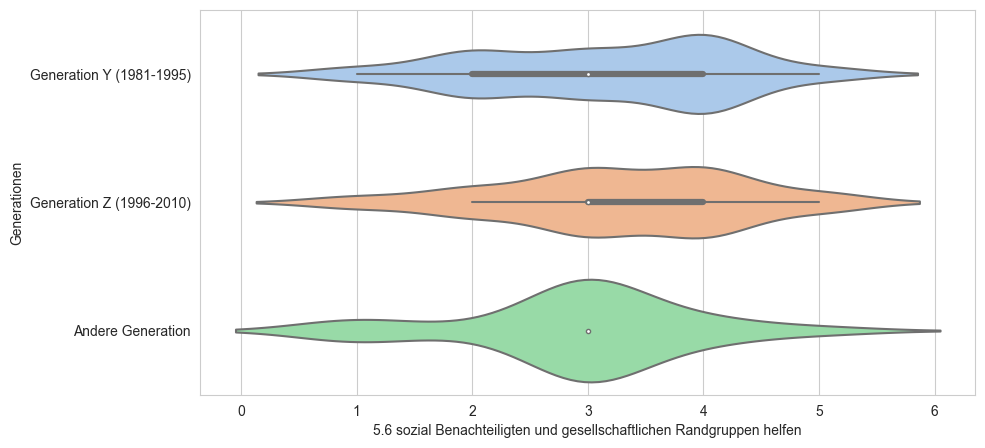

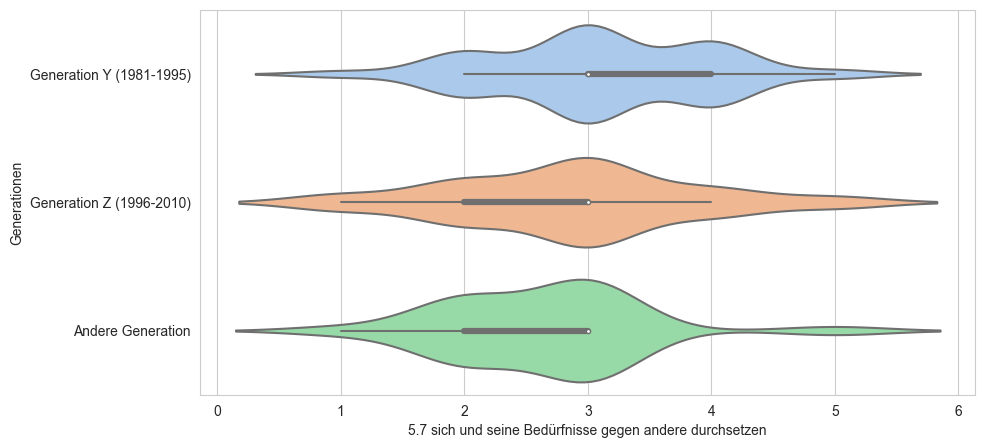

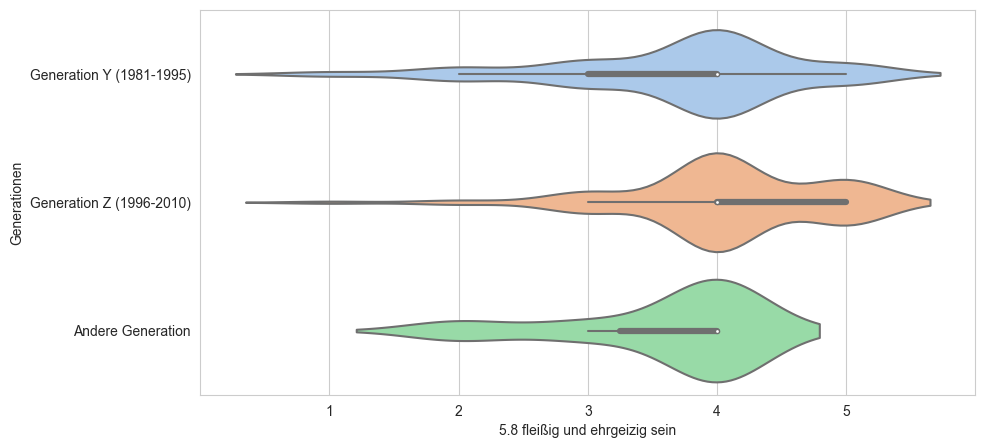

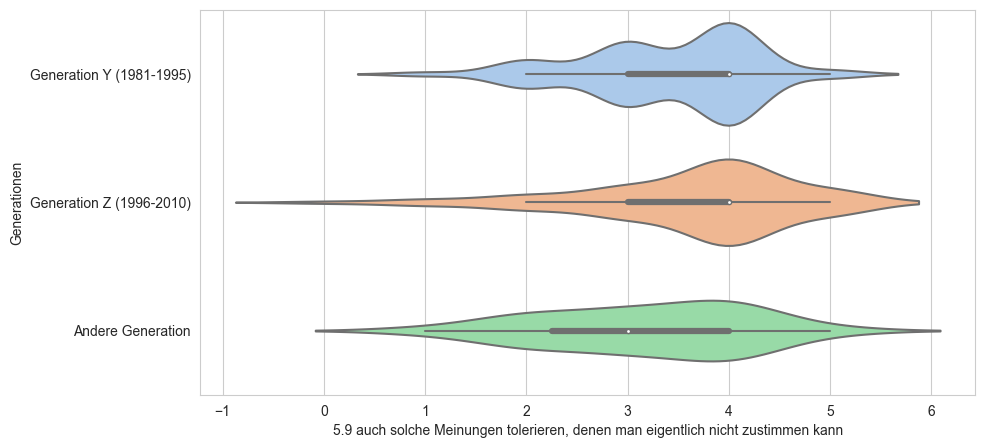

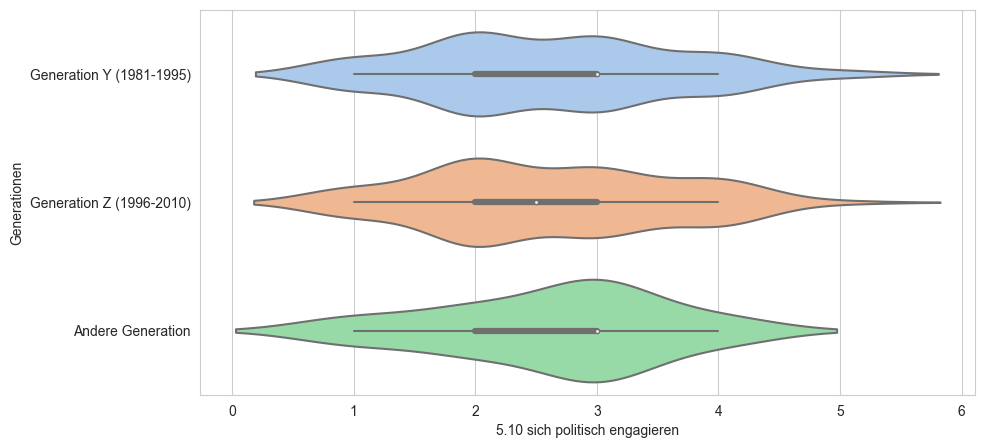

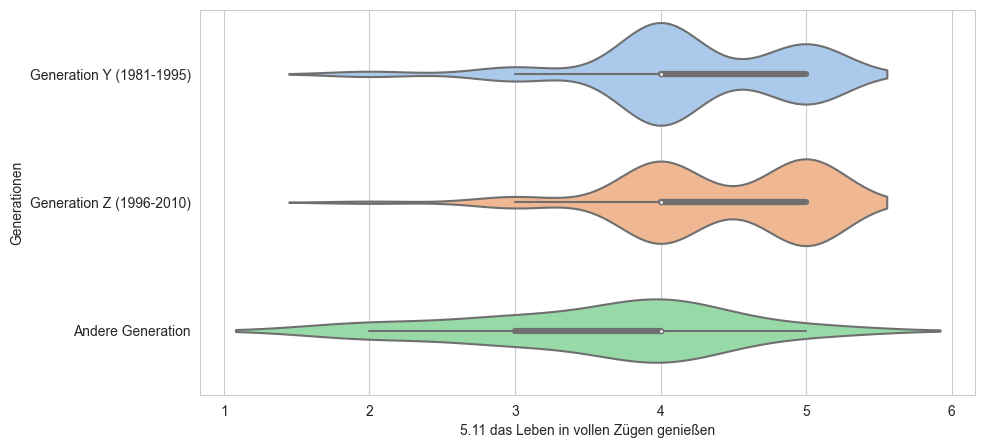

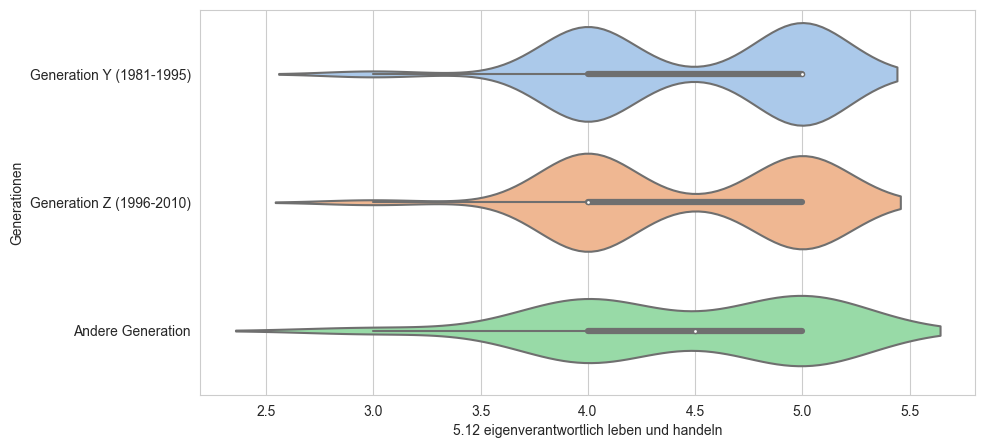

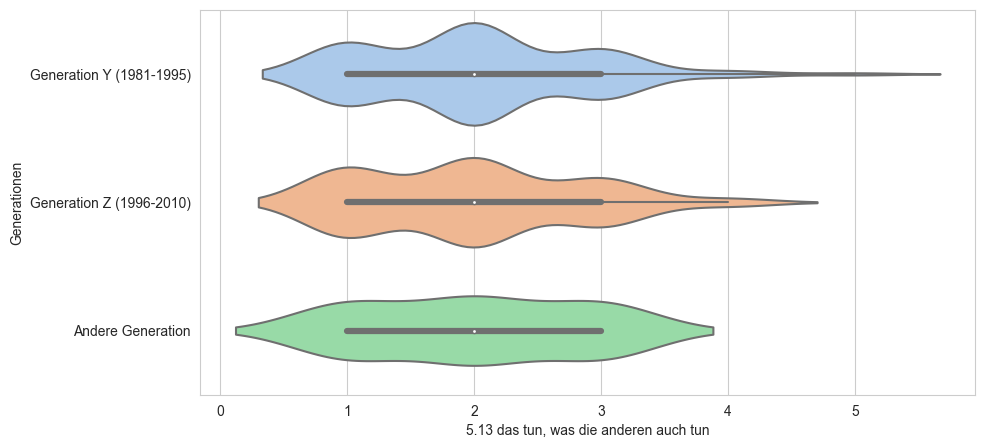

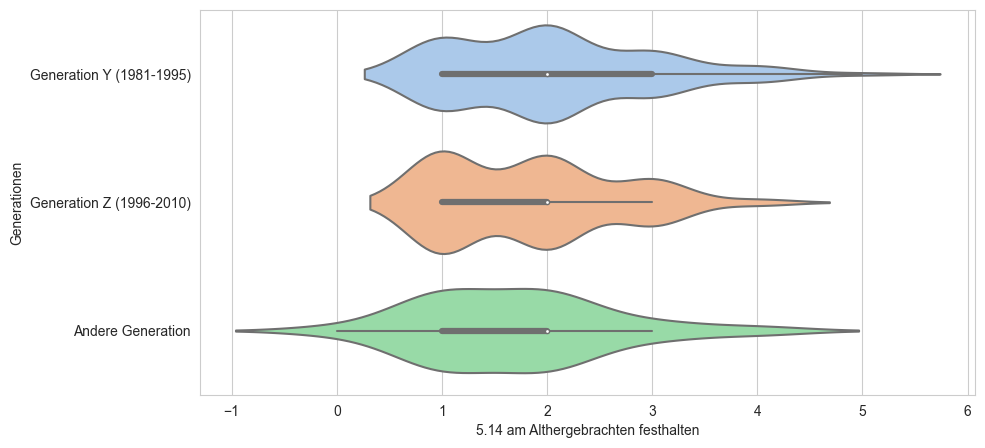

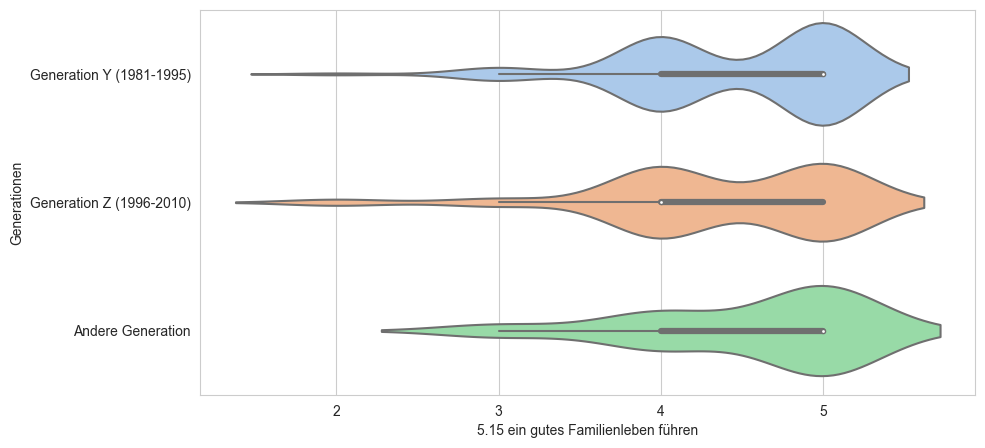

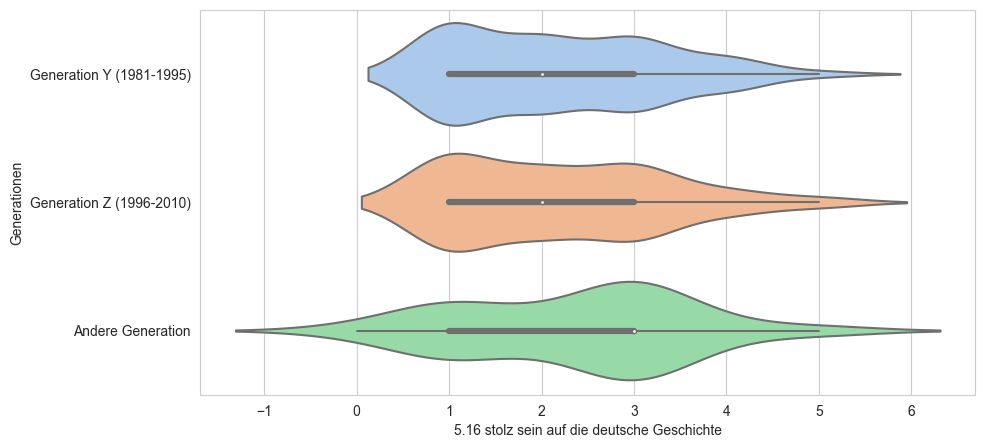

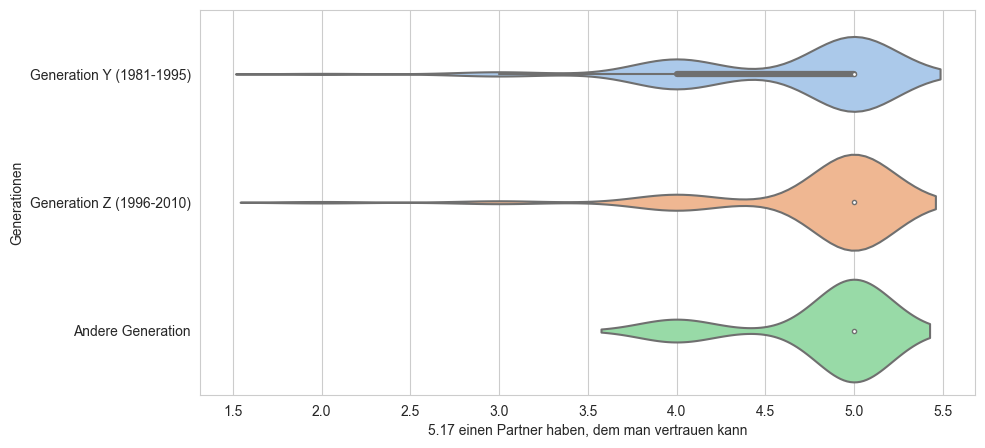

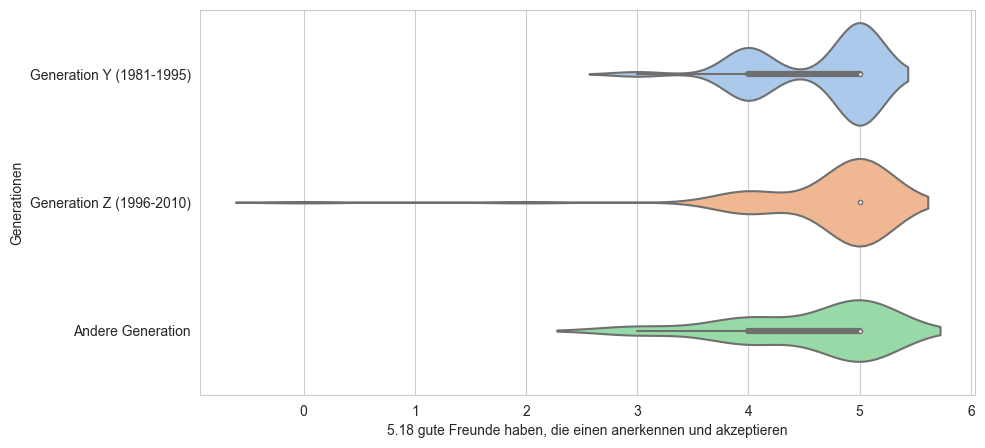

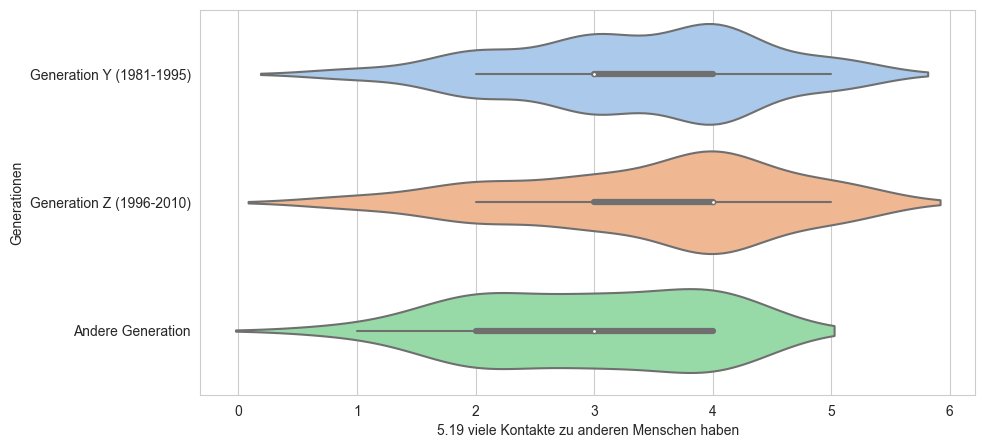

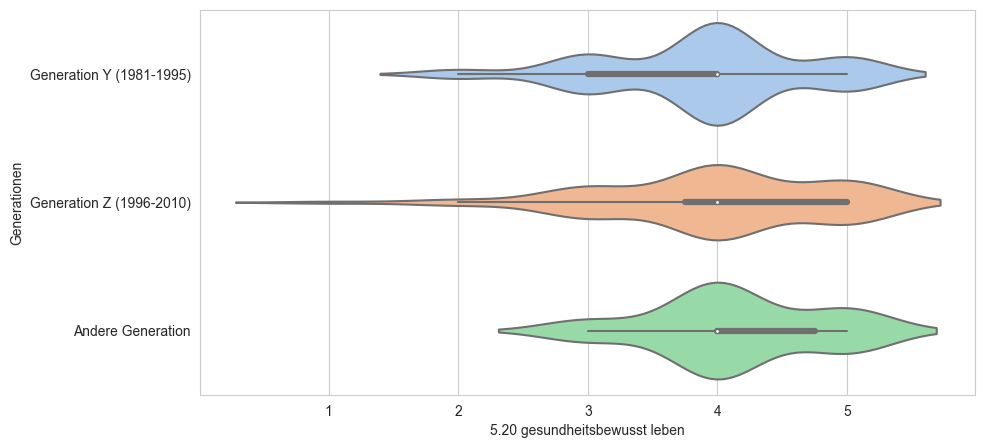

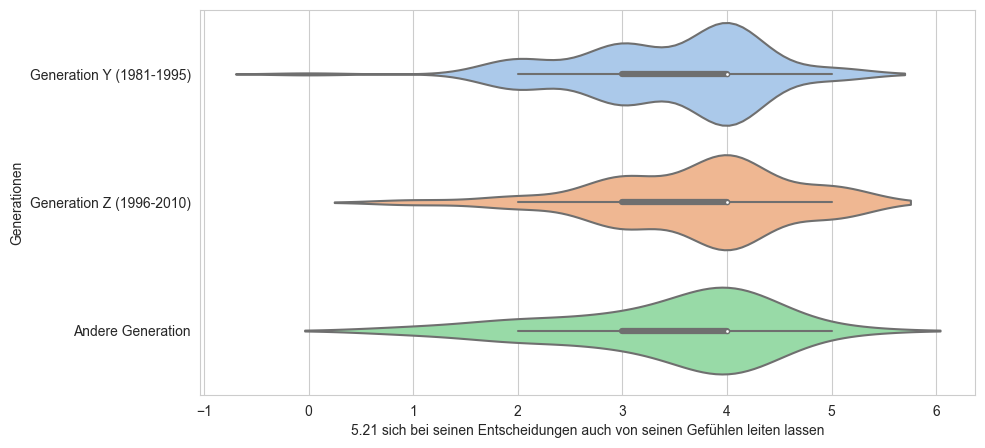

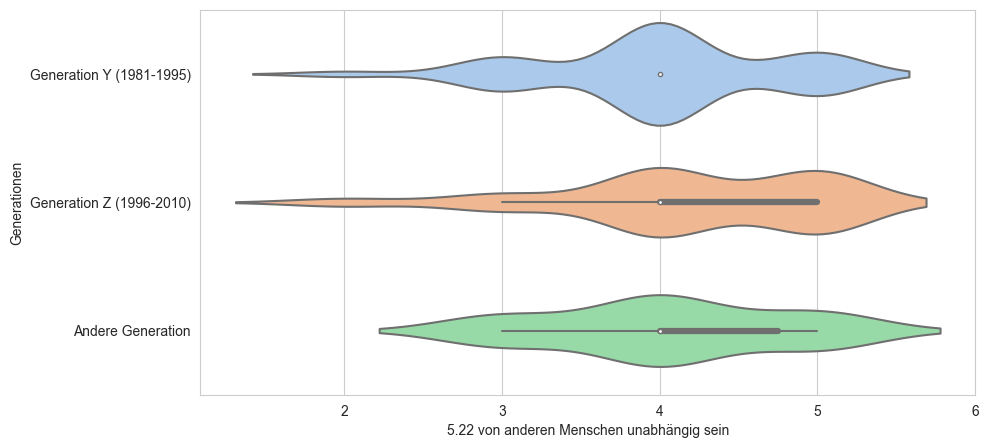

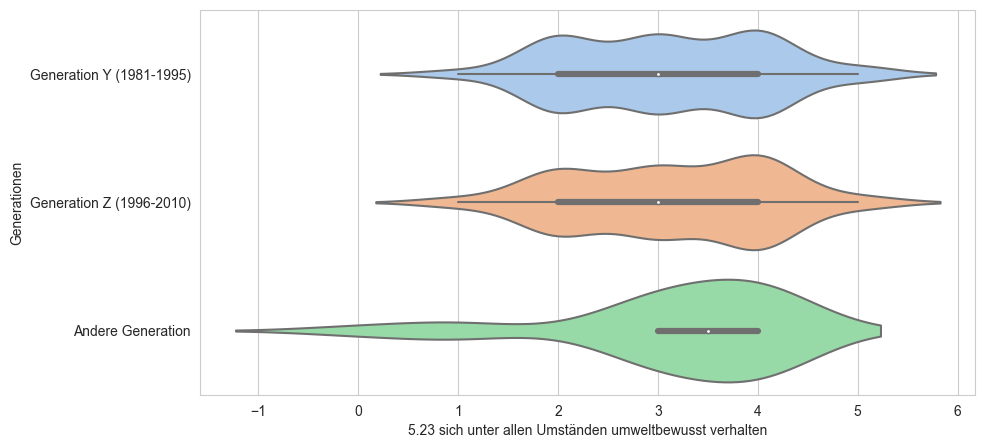

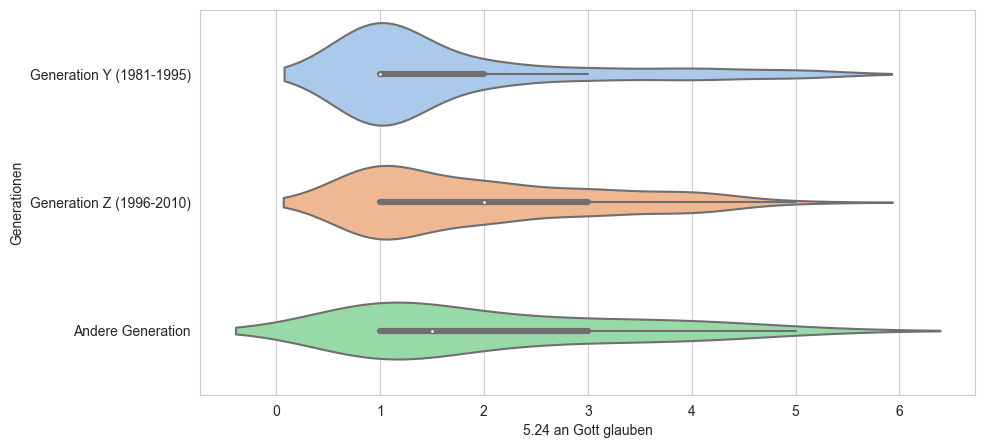

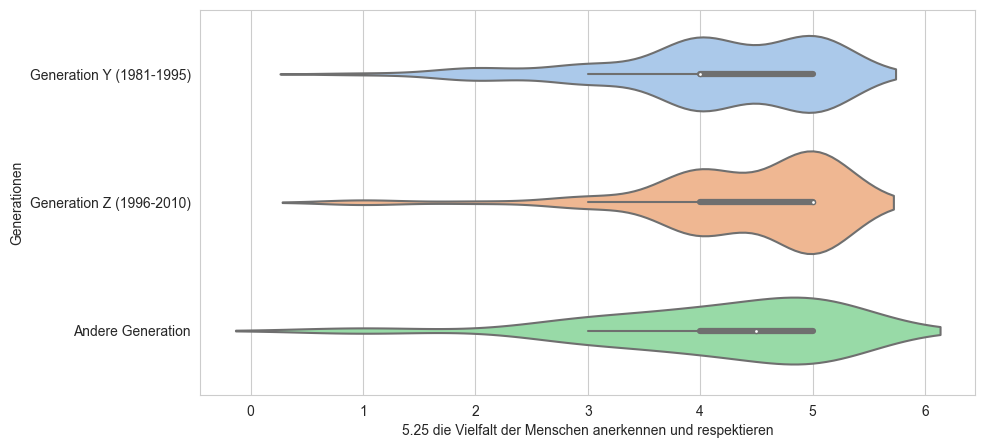

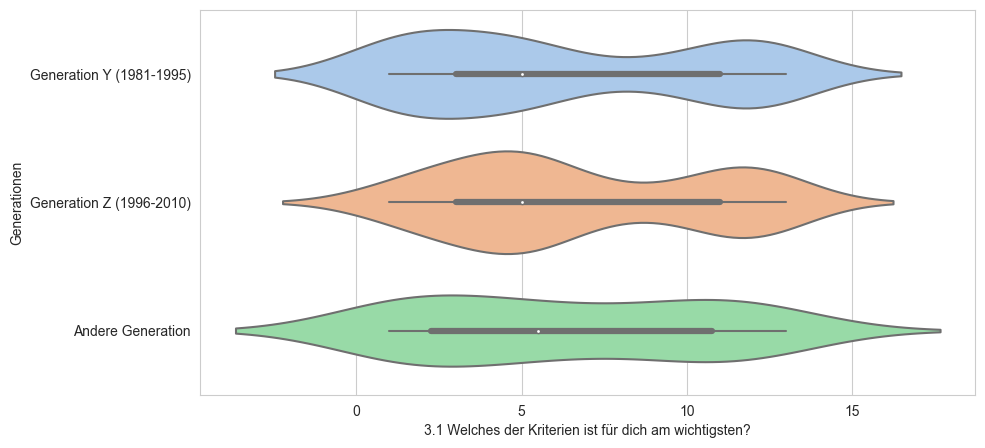

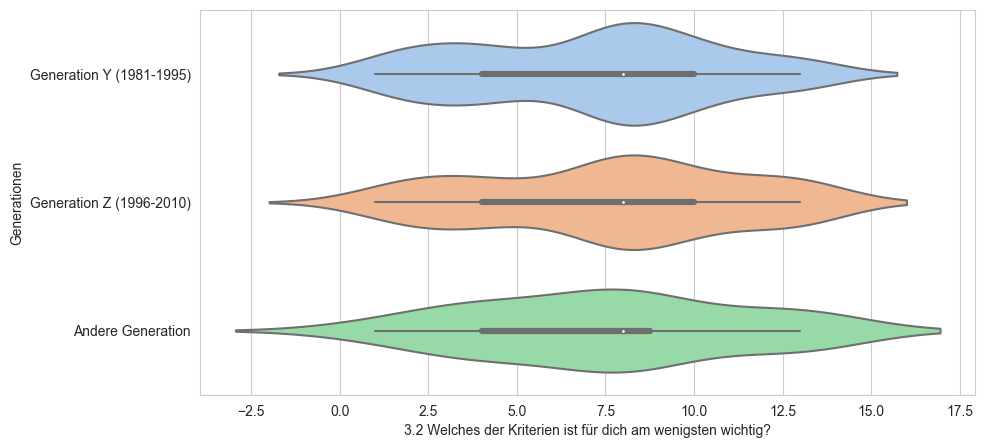

In [250]:
for col in num_fach_cols:
    plt.figure(figsize=(10,5))
    fig = sns.violinplot(data=df_results, x=col, y=generation_col, orient='h')
    plt.ylabel("Generationen")
    fig.axes.set_yticklabels(labels=["Generation Y (1981-1995)", "Generation Z (1996-2010)", "Andere Generation"])
    plt.xlabel(get_question_text(col))
    #plt.title("Anteile an der Stichprobengesamtheit klassifiziert nach Generation und Wirtschaftsektor der Beschäftigung")
    plt.show(fig)

In [27]:
df_results[gen_col]

Bogen
1      2
2      1
3      1
4      1
5      1
      ..
201    2
202    2
203    2
204    1
205    1
Name: 60371649, Length: 205, dtype: int64

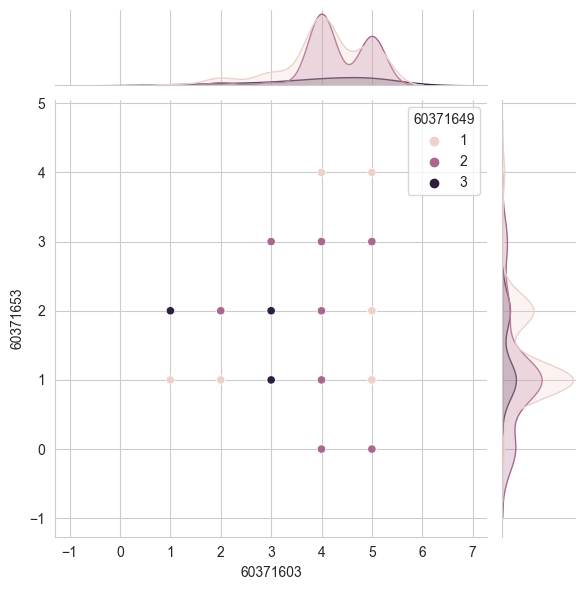

In [351]:
sns.jointplot(data=df_results, x='60371603', y=work_form_col, hue=generation_col)